In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
import torch
import argparse
import pickle
import datetime
import os
import re

from copy import deepcopy
from matplotlib import pyplot as plt
from collections import Counter
from io import StringIO
from Bio import Phylo
from ete3 import Tree

from VIPR import VIPR

In [24]:
dataset = "DS2" #["DS1","DS2","DS3","DS4","DS5","DS6","DS7","DS8","DS9","DS10","DS11","DS14"]
method = "reinforce" #["reparam","reinforce","VIMCO"]
alpha = 0.01 #[0.03,0.01,0.003,0.001]
rand_seed = 0

np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
data_file = '../dat/'+dataset+'/'+dataset+'.pickle'
out_file = '../results/'+dataset+'/'+dataset+'_'+method+'_'+str(alpha)+'_'+str(rand_seed)+'_'+time+'.pickle'

In [25]:
# keep fixed values
decay = "exp"
batch_size = 10
max_iters = 1000#200000
record_every = 100
test_batch_size = 100
if decay == "linear":
    linear_decay = True
else:
    linear_decay = False
anneal_freq = 1
anneal_rate = 0.01**(1.0/max_iters)
pop_size = 5.0
max_time = 0.1 # HOURS

In [26]:
with open(data_file, 'rb') as f:
    ds = pickle.load(f)
    
genomes = []
species = []
for key in ds:
    genomes.append(ds[key])
    species.append(key)

ntaxa = len(species)

# Type of Trees

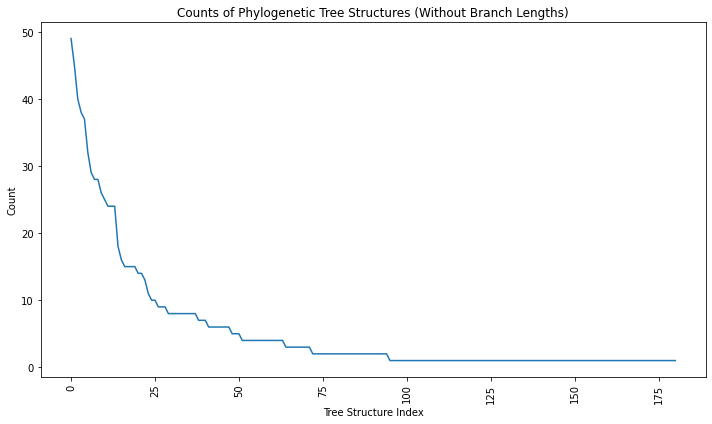

In [27]:
treedata = ""
ntrees = 0

for i in range(10):
    tree_file = "../dat/"+dataset+"/"+dataset+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)
    with open(tree_file, "r") as file:
        for j,line in enumerate(file):
            if j%10 == 0 and line.startswith("tree STATE"):
                line = line[line.find('('):]
                line = line.replace("[&rate=1.0]","")
                treedata = treedata + line + "\n"
                ntrees += 1
trees = Phylo.parse(StringIO(treedata), "newick")

def convert_tree_to_newick_without_lengths(tree):
    """Convert a tree to Newick format, ignoring branch lengths."""
    for clade in tree.find_clades():
        clade.branch_length = None  # Remove the branch lengths
    
    newick = StringIO()
    Phylo.write(tree, newick, "newick")
    return newick.getvalue().strip()

def remove_branch_lengths(newick_str):
    """
    Remove branch lengths from a Newick string.
    This uses a regex to remove any colon followed by a number (with optional decimal or exponent).
    """
    # The regex matches a colon followed by an optional sign, digits, optional decimal part,
    # and an optional exponent.
    return re.sub(r":[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?", "", newick_str)

structure_counter = Counter()

# Iterate over the trees and convert each one to Newick format
for i,tree in enumerate(trees):
        
    newick_str = convert_tree_to_newick_without_lengths(tree)
    structure_str = remove_branch_lengths(newick_str)
    structure_counter[structure_str] += 1

# Extract labels (tree structure strings) and counts for plotting
tree_labels = list(structure_counter.keys())
tree_counts = list(structure_counter.values())

plt.figure(figsize=(10, 6))
plt.plot(sorted(tree_counts,reverse=True))
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel('Tree Structure Index')
plt.ylabel('Count')
plt.title('Counts of Phylogenetic Tree Structures (Without Branch Lengths)')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

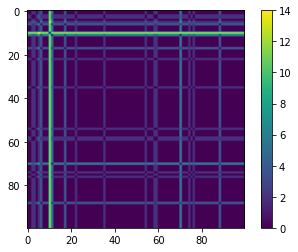

In [28]:
trees = []

for i in range(10):
    tree_file = "../dat/"+dataset+"/"+dataset+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)
    with open(tree_file, "r") as file:
        for j,line in enumerate(file):
            if j%100 == 0 and line.startswith("tree STATE"):
                line = line[line.find('('):]
                line = line.replace("[&rate=1.0]","")
                trees.append(Tree(line))
                
# Load trees from Newick files
ntrees = len(trees)
rf_dists = np.zeros((ntrees,ntrees))

for i in range(ntrees):
    for j in range(ntrees):
        rf_dists[i,j] = trees[i].robinson_foulds(trees[j])[0]
        
plt.imshow(rf_dists)
plt.colorbar()

# import $\theta$

In [29]:
treedata = ""
ntrees = 0
burnin = 100 + 2*ntaxa

for i in range(10):
    tree_file = "../dat/"+dataset+"/"+dataset+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)
    with open(tree_file, "r") as file:
        for j,line in enumerate(file):
            if j > burnin and j%10 == 0 and line.startswith("tree STATE"):
                line = line[line.find('('):]
                line = line.replace("[&rate=1.0]","")
                treedata = treedata + line + "\n"
                ntrees += 1

theta0 = torch.zeros((2,ntaxa,ntaxa))
trees = Phylo.parse(StringIO(treedata), "newick")
dists = np.zeros((ntrees,ntaxa,ntaxa))

print(ntrees)

for i,tree in enumerate(trees):
    
    if i % int(ntrees/100) == 0:
        print(i)
        
    for j in range(ntaxa):
        for k in range(j):
            dists[i,j,k] = tree.distance(target1=str(j+1),target2=str(k+1))/2.0

for j in range(ntaxa):
    for k in range(j):
        theta0[0,j,k] = np.mean(dists[:,j,k])
        theta0[1,j,k] = np.var(dists[:,j,k])

# add random noise
if rand_seed > 0:
    theta0 = theta0 + torch.normal(mean=0.0,std=rand_seed*0.1,size=(2,ntaxa,ntaxa))

910
0
9
18
27
36
45
54
63
72
81
90
99
108
117
126
135
144
153
162
171
180
189
198
207
216
225
234
243
252
261
270
279
288
297
306
315
324
333
342
351
360
369
378
387
396
405
414
423
432
441
450
459
468
477
486
495
504
513
522
531
540
549
558
567
576
585
594
603
612
621
630
639
648
657
666
675
684
693
702
711
720
729
738
747
756
765
774
783
792
801
810
819
828
837
846
855
864
873
882
891
900
909


1 0
0.0
0.0


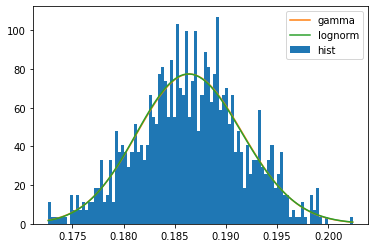

2 0
0.0
0.0


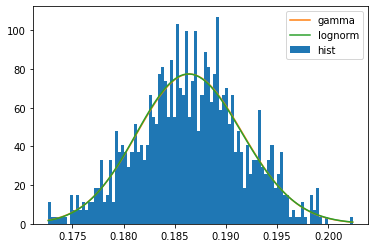

2 1
0.0
0.0


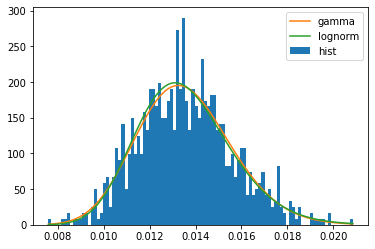

3 0
0.0
0.0


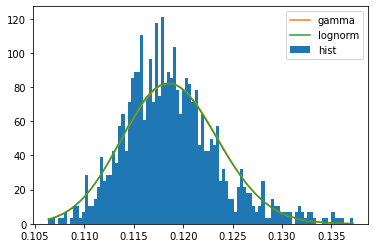

3 1
0.0
0.0


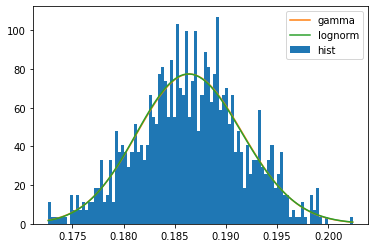

3 2
0.0
0.0


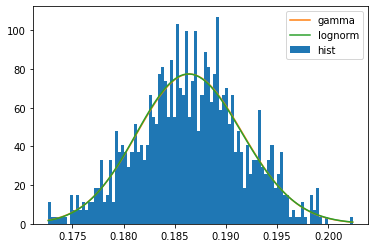

4 0
0.0
0.0


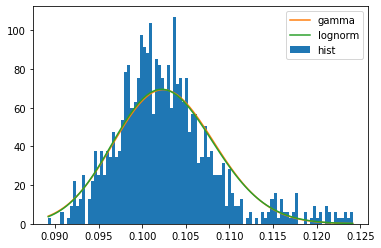

4 1
0.0
0.0


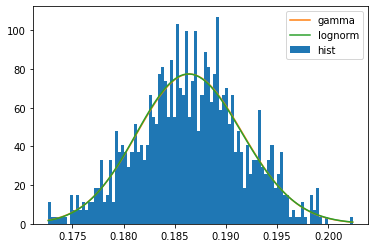

4 2
0.0
0.0


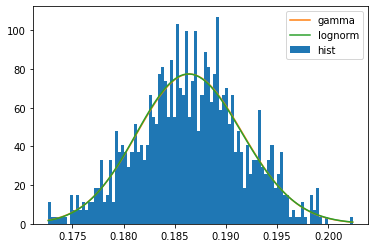

4 3
0.0
0.0


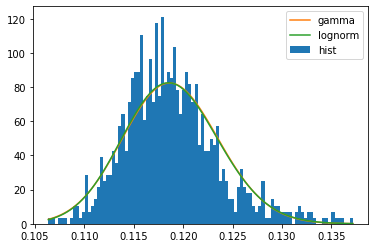

5 0
0.0
0.0


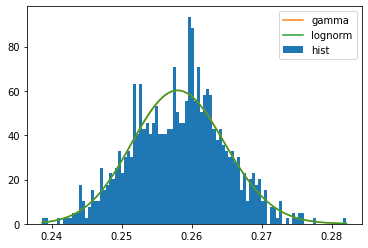

5 1
0.0
0.0


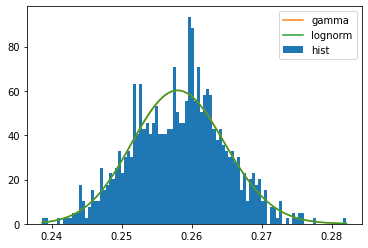

5 2
0.0
0.0


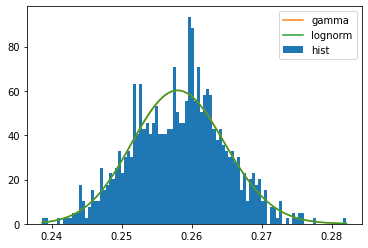

5 3
0.0
0.0


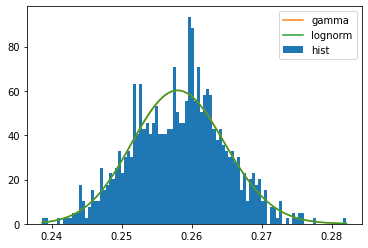

5 4
0.0
0.0


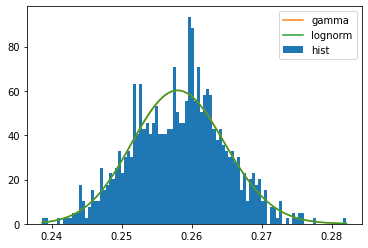

6 0
0.0
0.0


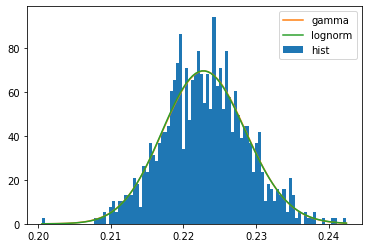

6 1
0.0
0.0


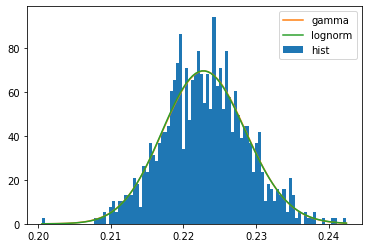

6 2
0.0
0.0


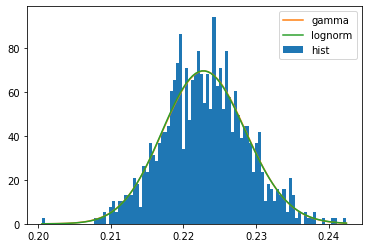

6 3
0.0
0.0


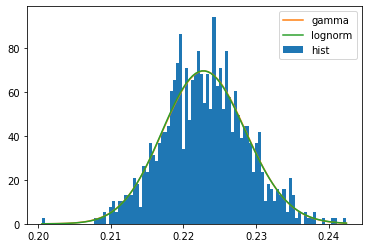

6 4
0.0
0.0


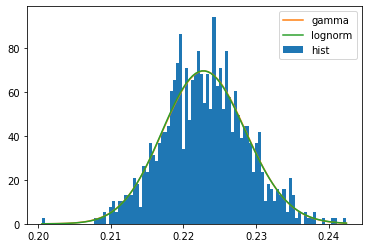

6 5
0.0
0.0


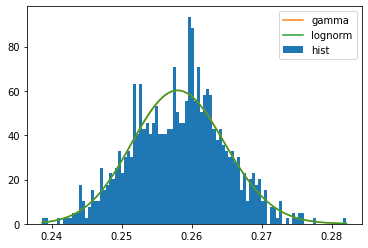

7 0
0.0
0.0


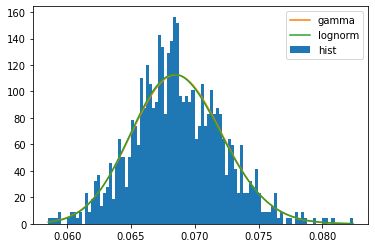

7 1
0.0
0.0


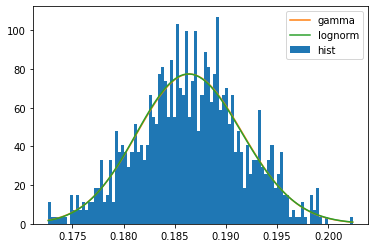

7 2
0.0
0.0


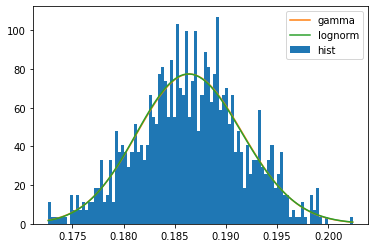

7 3
0.0
0.0


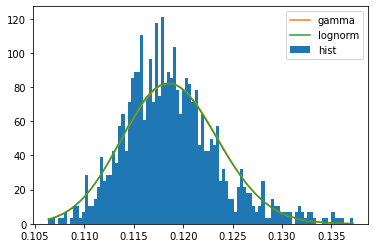

7 4
0.0
0.0


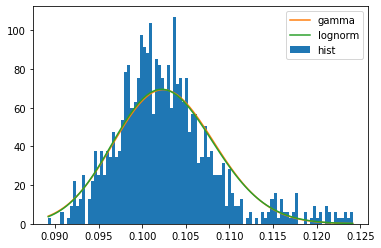

7 5
0.0
0.0


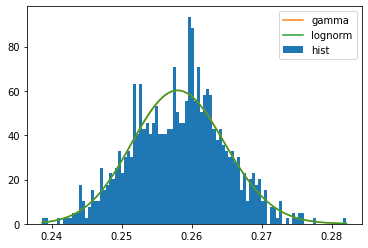

7 6
0.0
0.0


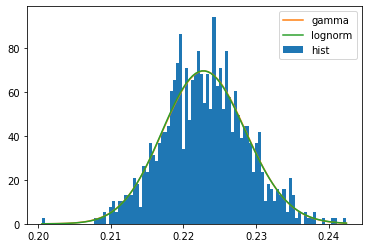

8 0
0.0
0.0


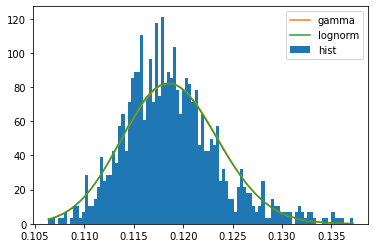

8 1
0.0
0.0


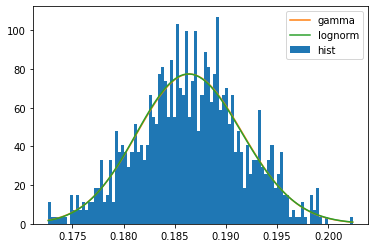

8 2
0.0
0.0


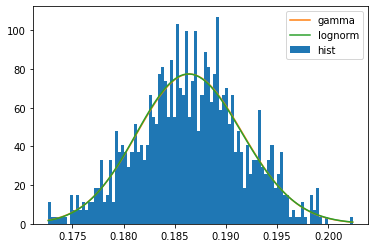

8 3
0.0
0.0


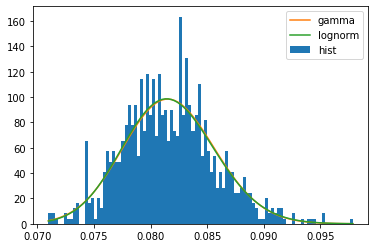

8 4
0.0
0.0


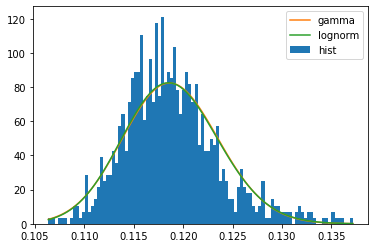

8 5
0.0
0.0


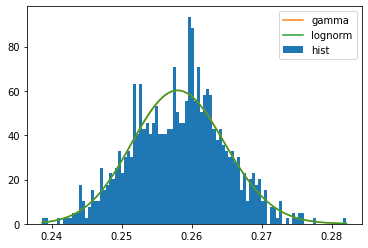

8 6
0.0
0.0


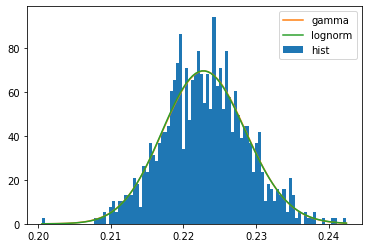

8 7
0.0
0.0


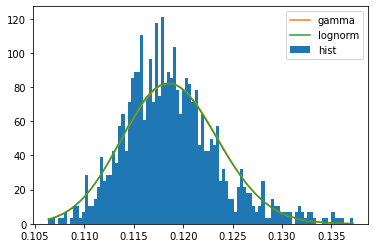

9 0
0.0
0.0


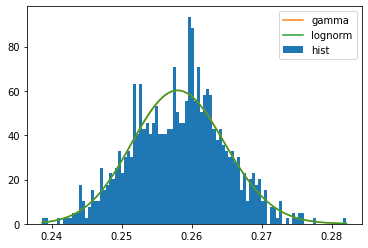

9 1
0.0
0.0


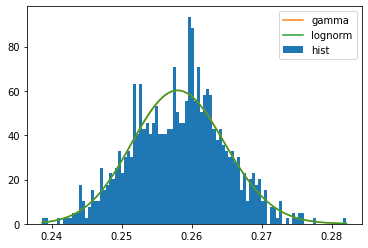

9 2
0.0
0.0


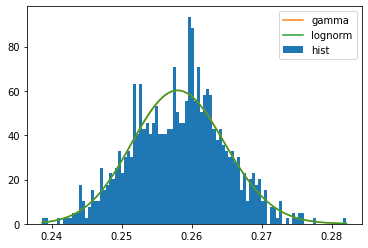

9 3
0.0
0.0


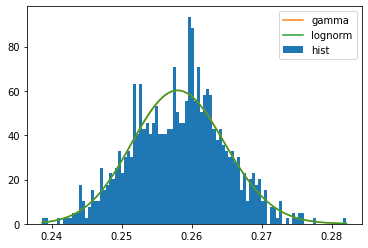

9 4
0.0
0.0


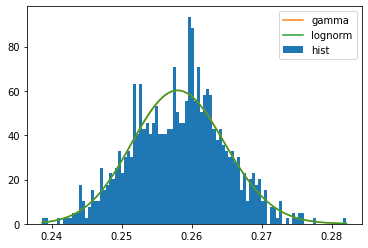

9 5
0.0
0.0


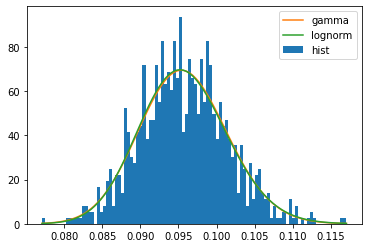

9 6
0.0
0.0


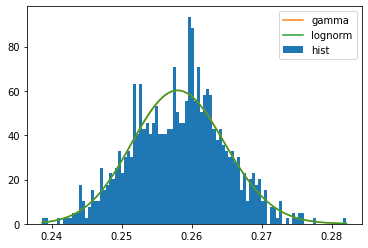

9 7
0.0
0.0


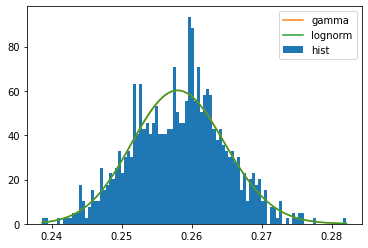

9 8
0.0
0.0


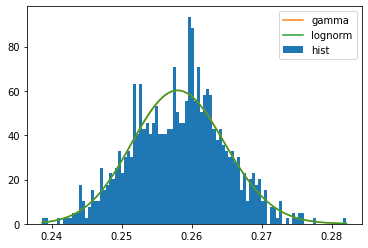

10 0
0.0
0.0


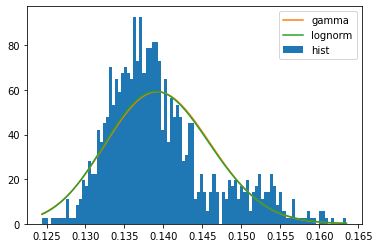

10 1
0.0
0.0


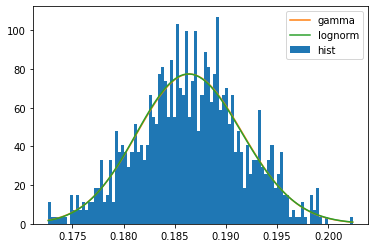

10 2
0.0
0.0


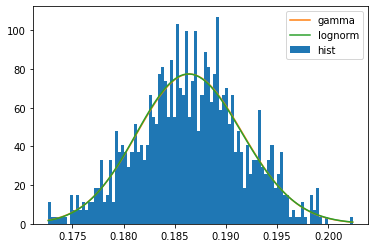

10 3
0.0
0.0


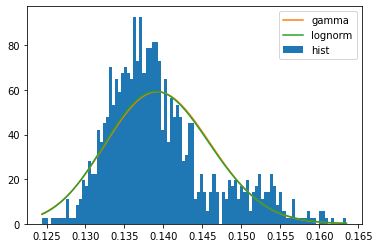

10 4
0.0
0.0


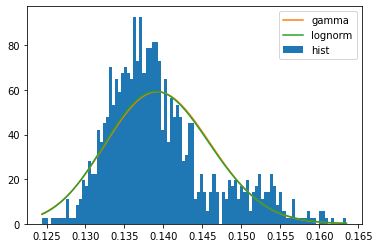

10 5
0.0
0.0


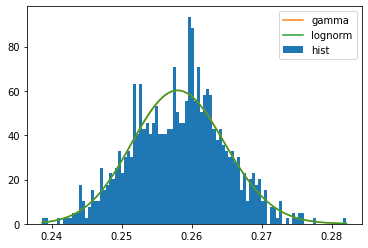

10 6
0.0
0.0


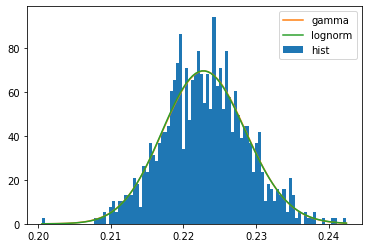

10 7
0.0
0.0


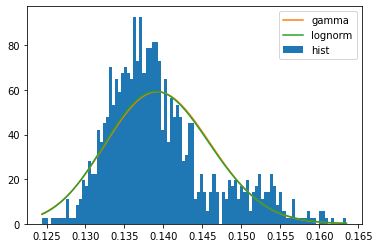

10 8
0.0
0.0


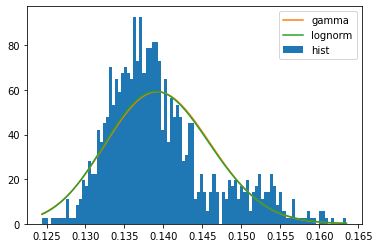

10 9
0.0
0.0


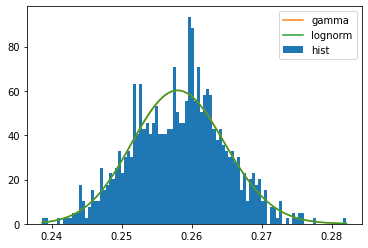

11 0
0.0
0.0


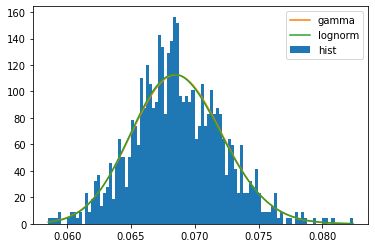

11 1
0.0
0.0


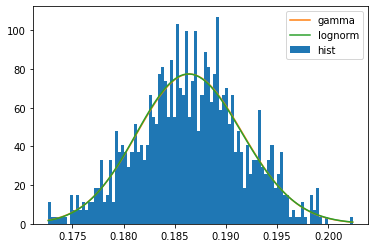

11 2
0.0
0.0


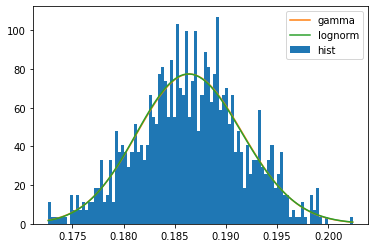

11 3
0.0
0.0


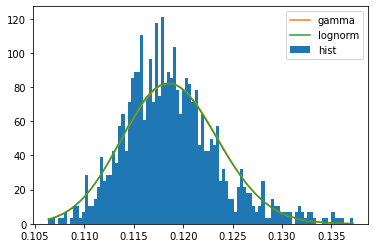

11 4
0.0
0.0


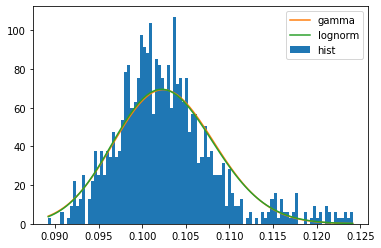

11 5
0.0
0.0


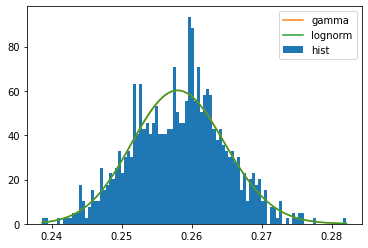

11 6
0.0
0.0


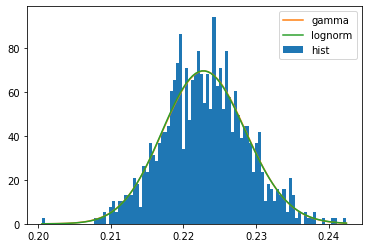

11 7
0.0
0.0


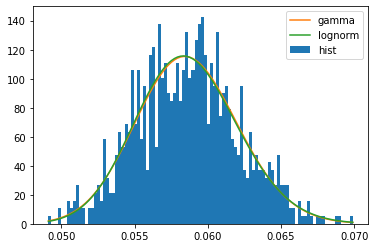

11 8
0.0
0.0


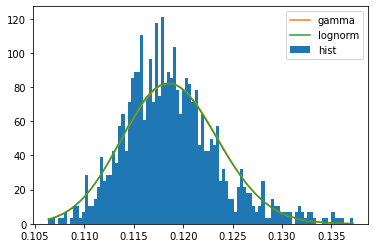

11 9
0.0
0.0


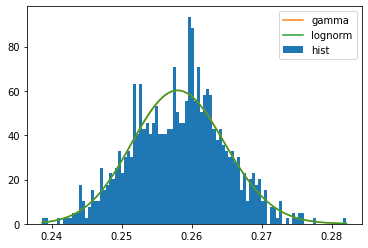

11 10
0.0
0.0


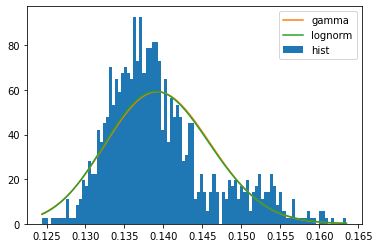

12 0
0.0
0.0


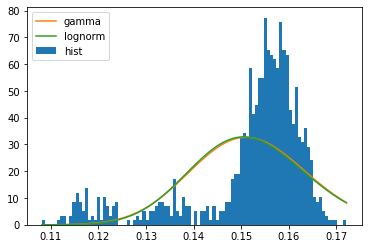

12 1
0.0
0.0


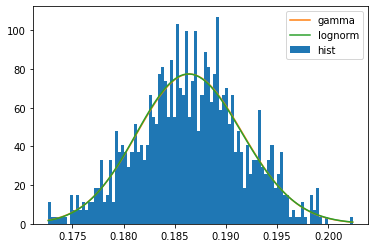

12 2
0.0
0.0


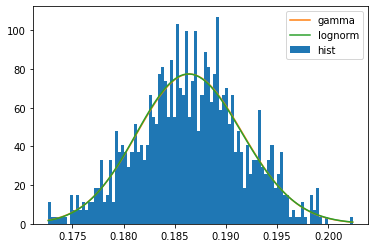

12 3
0.0
0.0


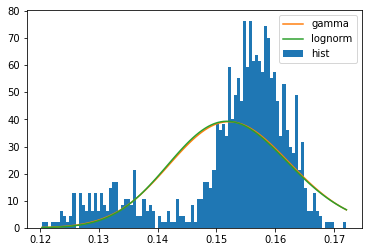

12 4
0.0
0.0


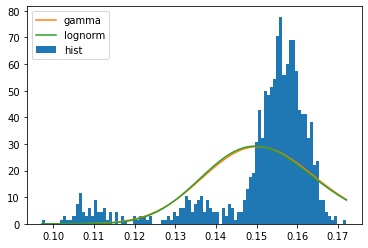

12 5
0.0
0.0


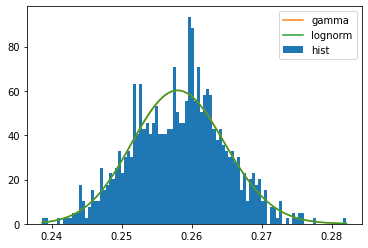

12 6
0.0
0.0


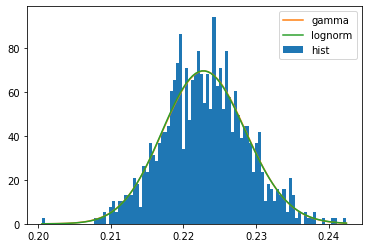

12 7
0.0
0.0


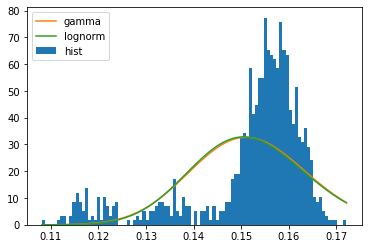

12 8
0.0
0.0


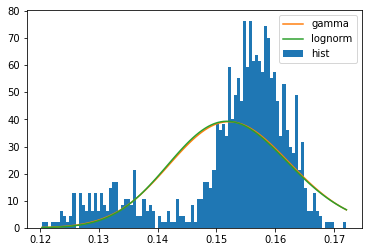

12 9
0.0
0.0


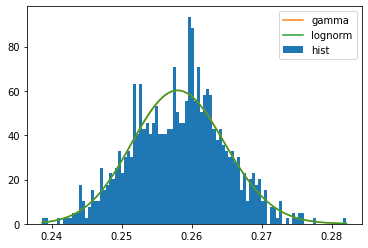

12 10
0.0
0.0


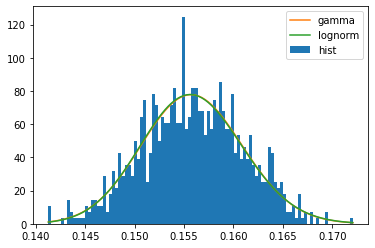

12 11
0.0
0.0


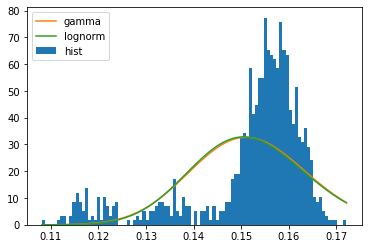

13 0
0.0
0.0


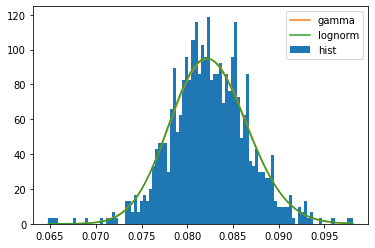

13 1
0.0
0.0


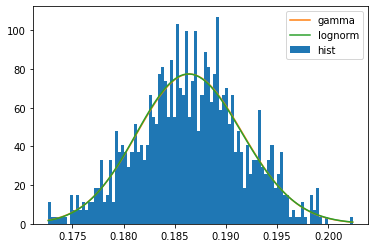

13 2
0.0
0.0


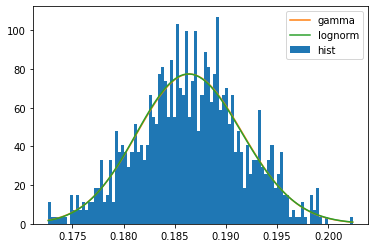

13 3
0.0
0.0


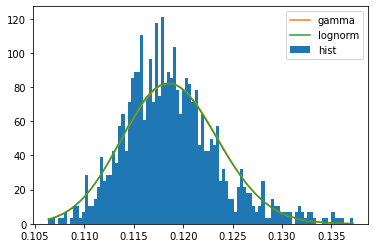

13 4
0.0
0.0


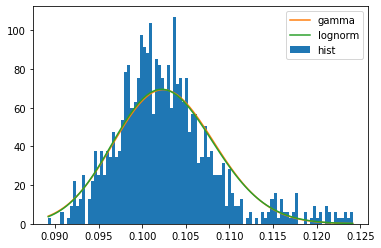

13 5
0.0
0.0


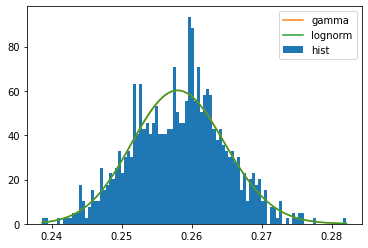

13 6
0.0
0.0


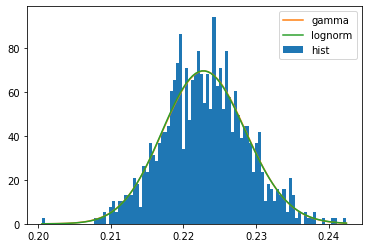

13 7
0.0
0.0


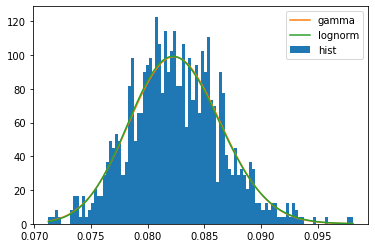

13 8
0.0
0.0


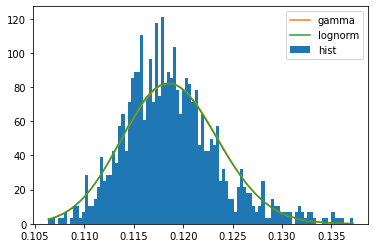

13 9
0.0
0.0


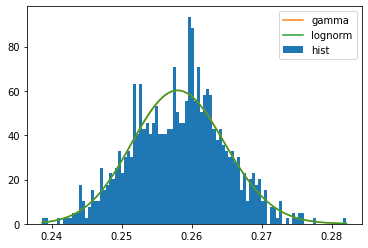

13 10
0.0
0.0


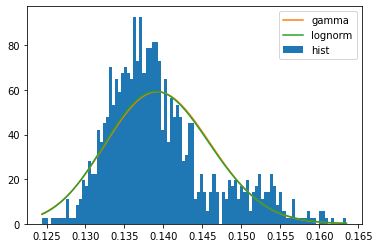

13 11
0.0
0.0


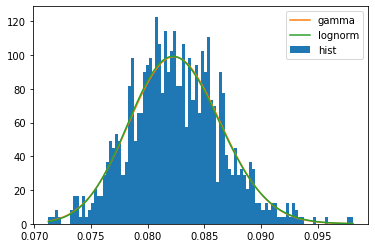

13 12
0.0
0.0


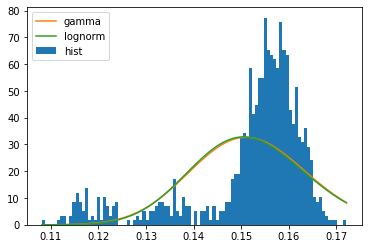

14 0
0.0
0.0


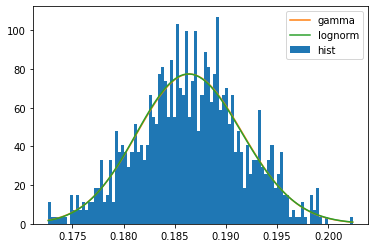

14 1
0.0
0.0


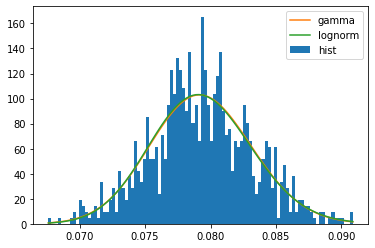

14 2
0.0
0.0


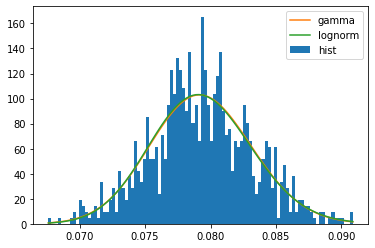

14 3
0.0
0.0


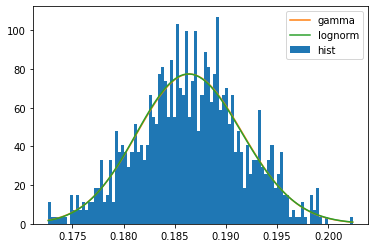

14 4
0.0
0.0


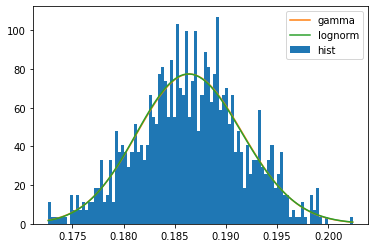

14 5
0.0
0.0


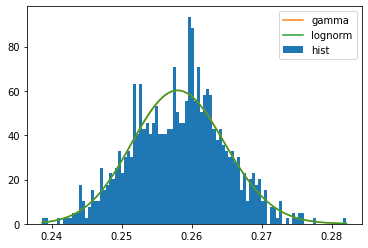

14 6
0.0
0.0


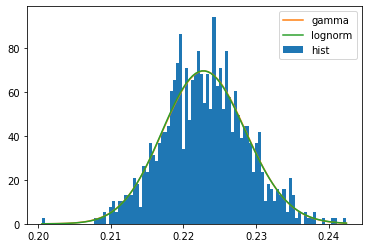

14 7
0.0
0.0


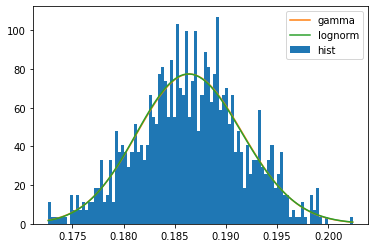

14 8
0.0
0.0


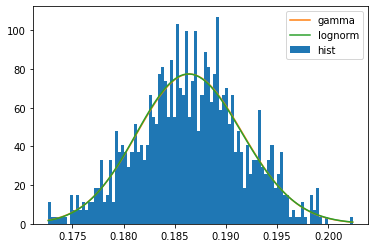

14 9
0.0
0.0


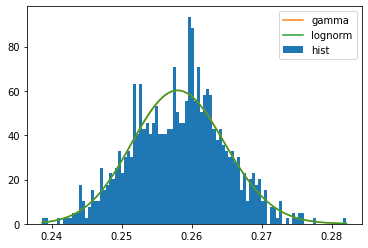

14 10
0.0
0.0


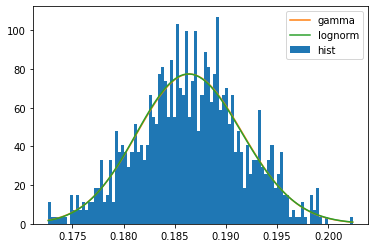

14 11
0.0
0.0


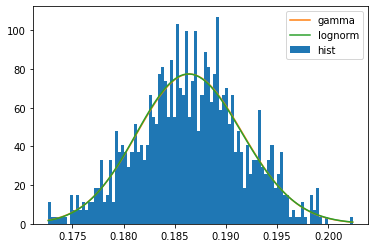

14 12
0.0
0.0


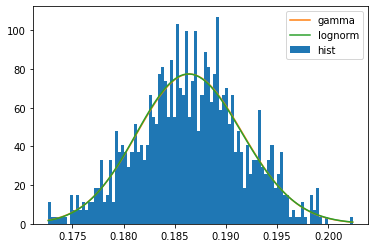

14 13
0.0
0.0


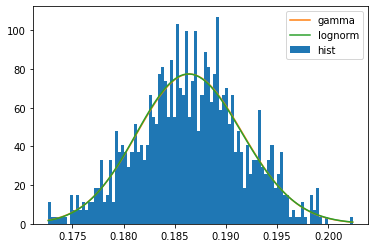

15 0
0.0
0.0


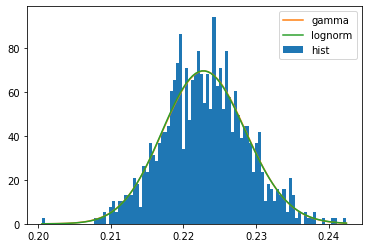

15 1
0.0
0.0


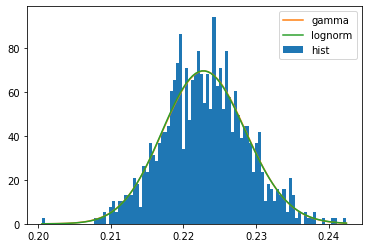

15 2
0.0
0.0


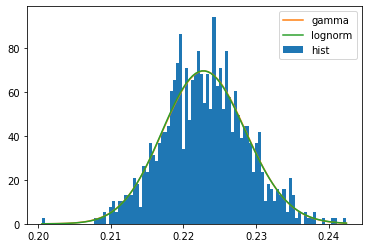

15 3
0.0
0.0


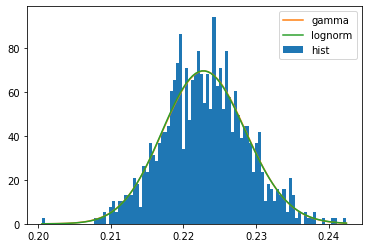

15 4
0.0
0.0


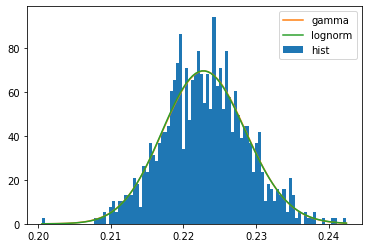

15 5
0.0
0.0


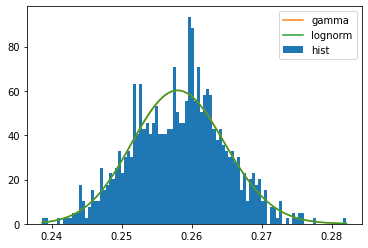

15 6
0.0
0.0


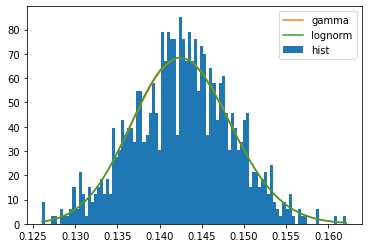

15 7
0.0
0.0


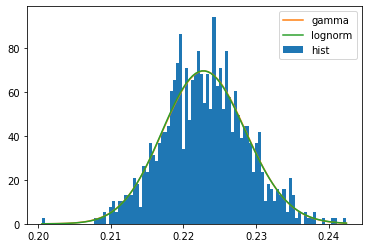

15 8
0.0
0.0


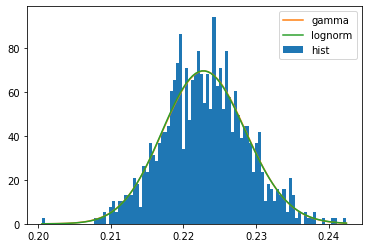

15 9
0.0
0.0


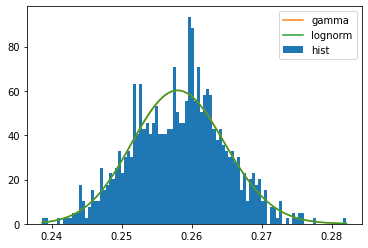

15 10
0.0
0.0


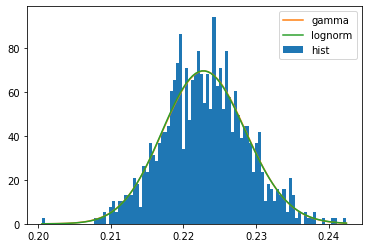

15 11
0.0
0.0


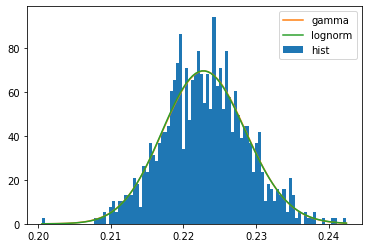

15 12
0.0
0.0


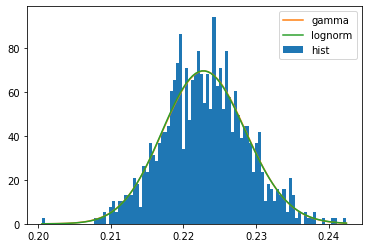

15 13
0.0
0.0


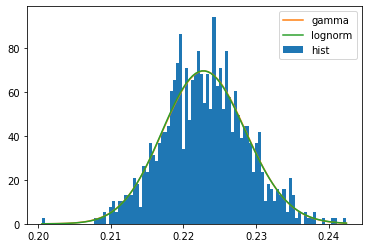

15 14
0.0
0.0


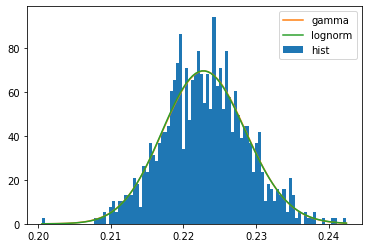

16 0
0.0
0.0


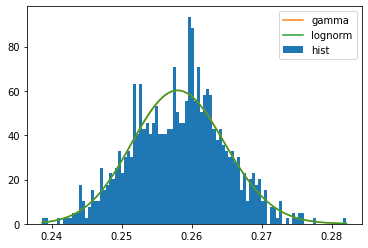

16 1
0.0
0.0


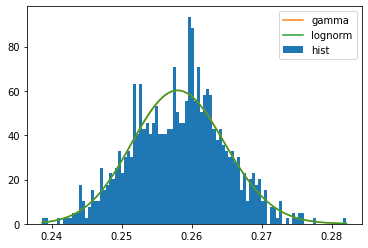

16 2
0.0
0.0


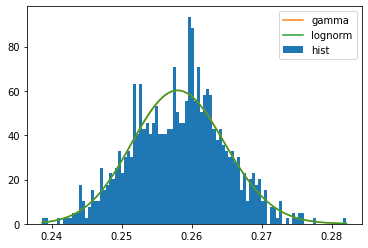

16 3
0.0
0.0


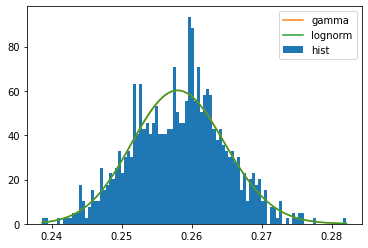

16 4
0.0
0.0


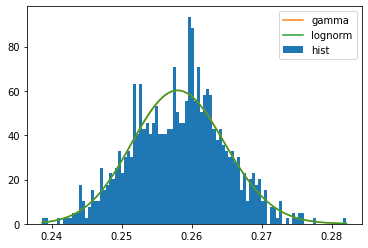

16 5
0.0
0.0


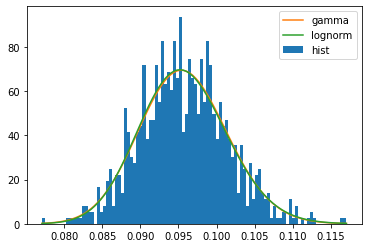

16 6
0.0
0.0


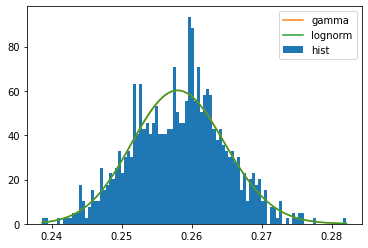

16 7
0.0
0.0


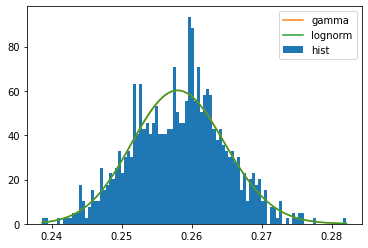

16 8
0.0
0.0


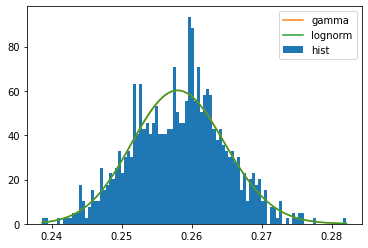

16 9
0.0
0.0


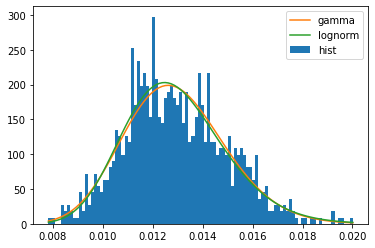

16 10
0.0
0.0


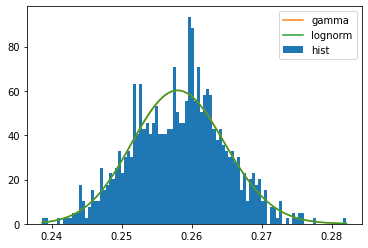

16 11
0.0
0.0


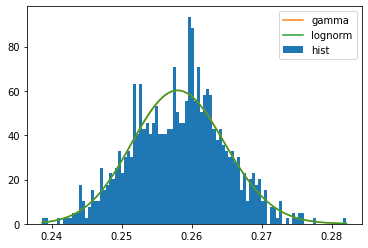

16 12
0.0
0.0


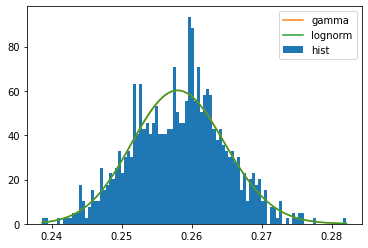

16 13
0.0
0.0


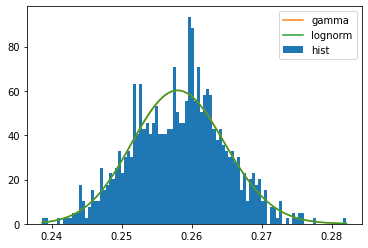

16 14
0.0
0.0


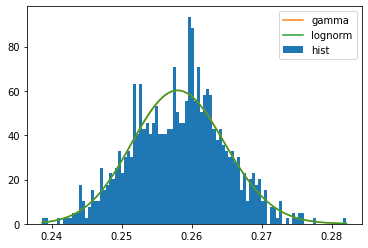

16 15
0.0
0.0


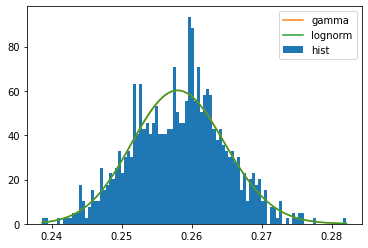

17 0
0.0
0.0


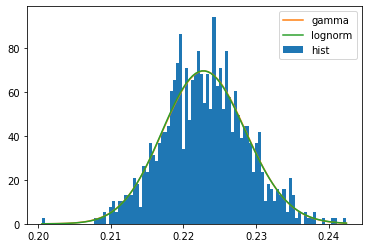

17 1
0.0
0.0


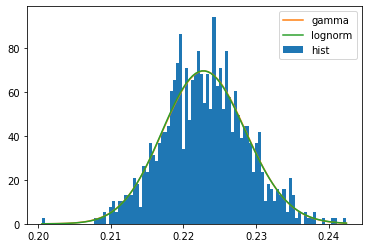

17 2
0.0
0.0


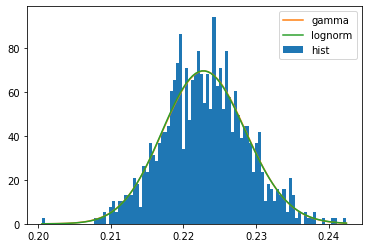

17 3
0.0
0.0


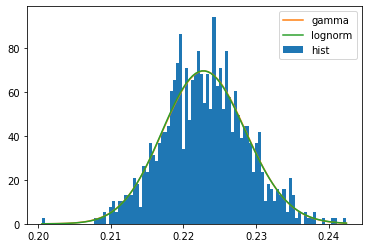

17 4
0.0
0.0


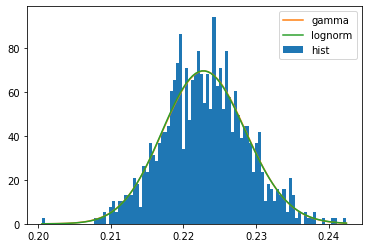

17 5
0.0
0.0


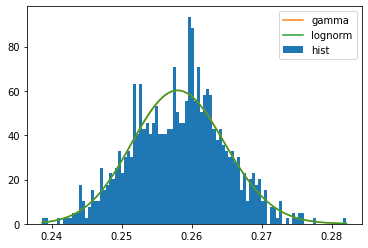

17 6
0.0
0.0


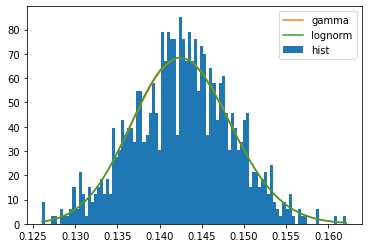

17 7
0.0
0.0


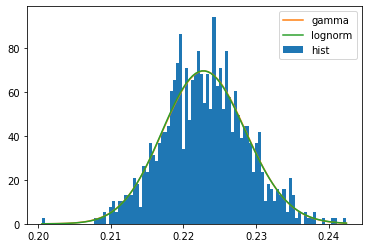

17 8
0.0
0.0


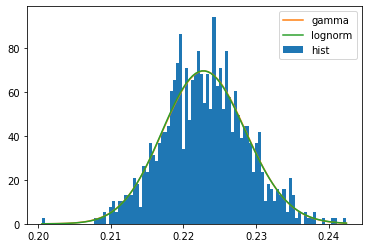

17 9
0.0
0.0


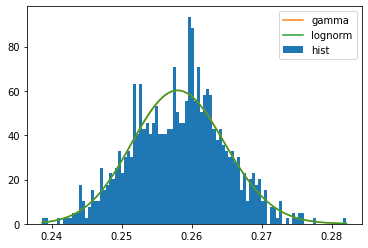

17 10
0.0
0.0


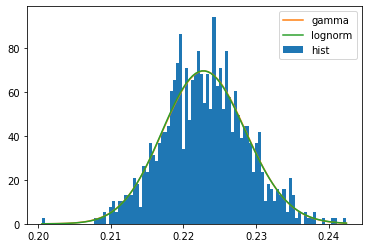

17 11
0.0
0.0


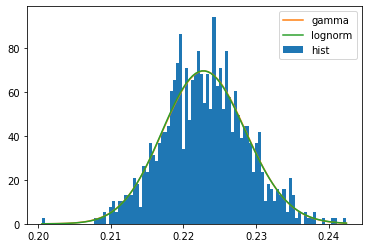

17 12
0.0
0.0


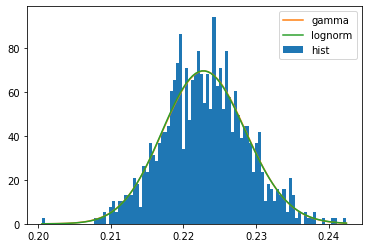

17 13
0.0
0.0


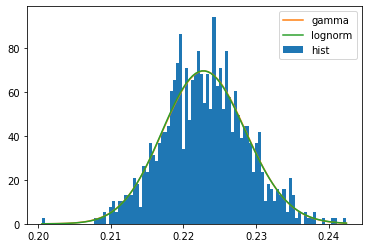

17 14
0.0
0.0


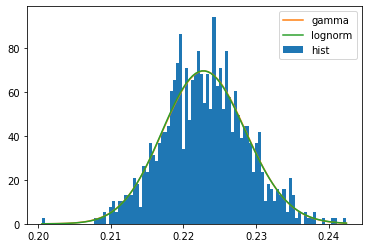

17 15
0.0
0.0


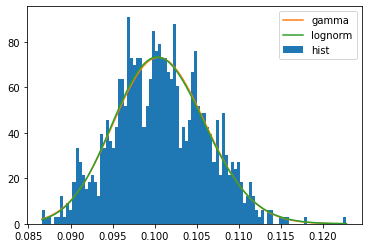

17 16
0.0
0.0


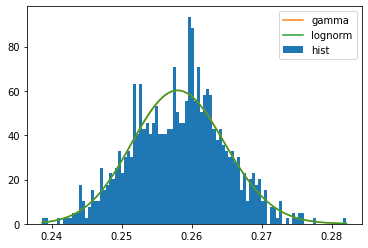

18 0
0.0
0.0


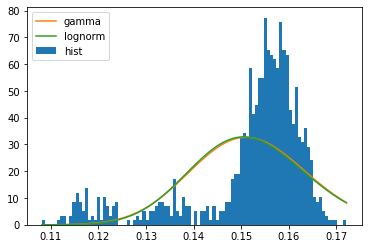

18 1
0.0
0.0


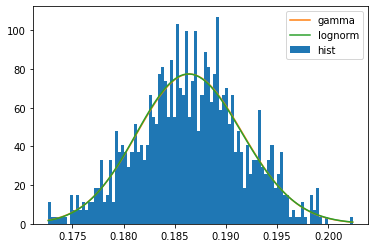

18 2
0.0
0.0


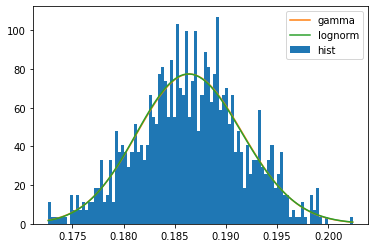

18 3
0.0
0.0


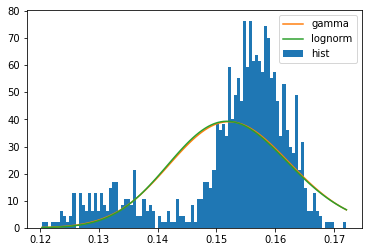

18 4
0.0
0.0


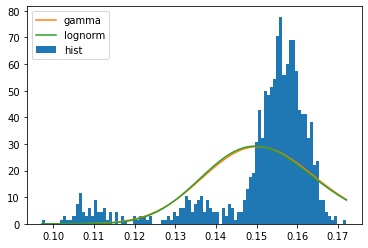

18 5
0.0
0.0


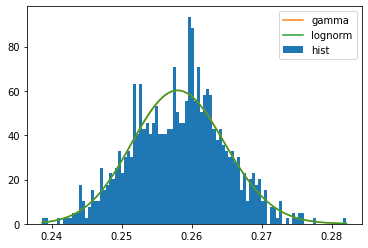

18 6
0.0
0.0


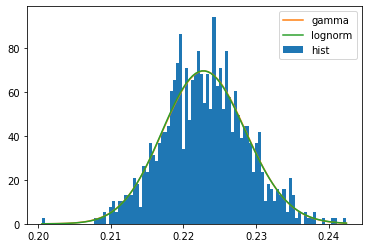

18 7
0.0
0.0


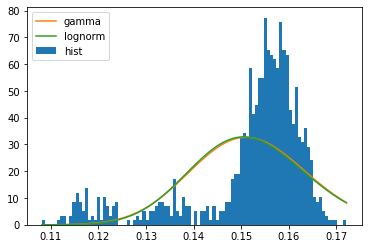

18 8
0.0
0.0


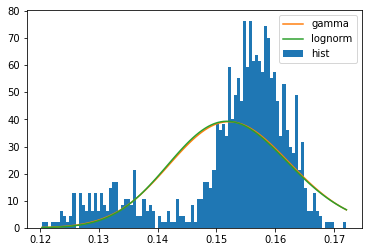

18 9
0.0
0.0


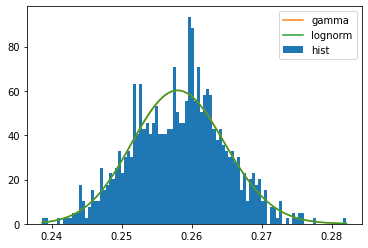

18 10
0.0
0.0


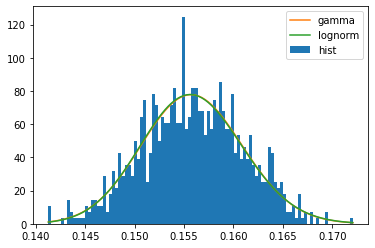

18 11
0.0
0.0


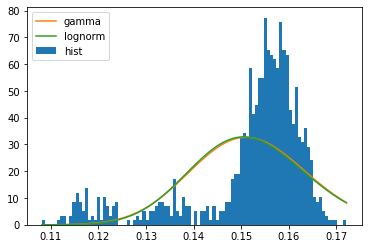

18 12
0.0
0.0


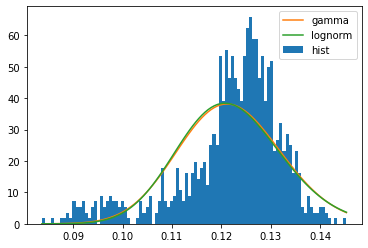

18 13
0.0
0.0


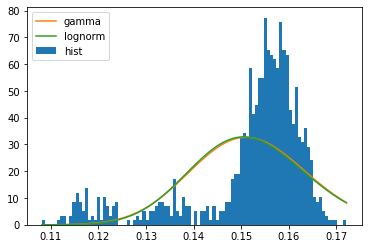

18 14
0.0
0.0


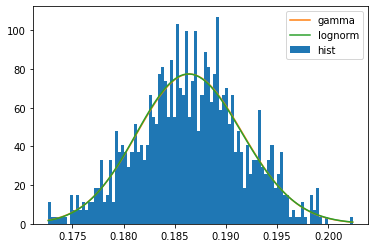

18 15
0.0
0.0


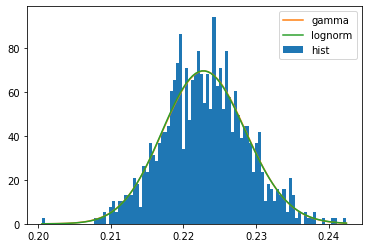

18 16
0.0
0.0


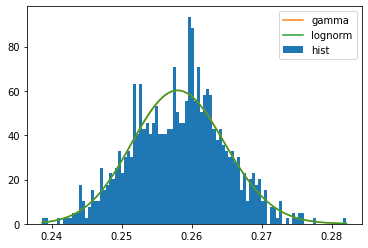

18 17
0.0
0.0


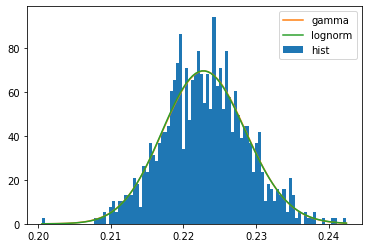

19 0
0.0
0.0


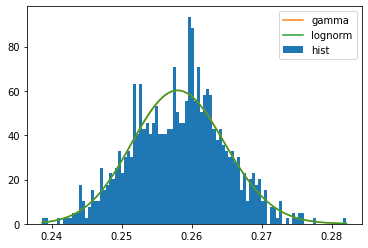

19 1
0.0
0.0


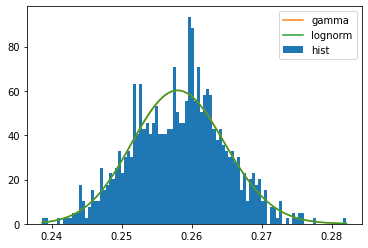

19 2
0.0
0.0


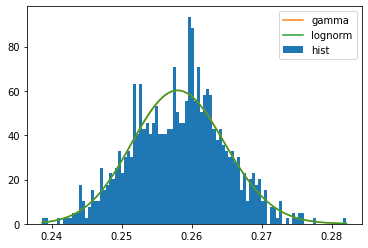

19 3
0.0
0.0


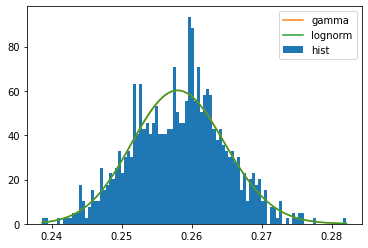

19 4
0.0
0.0


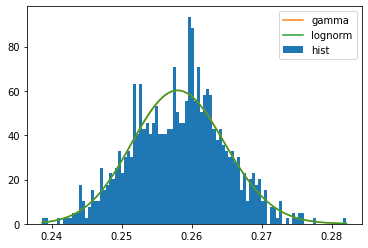

19 5
0.0
0.0


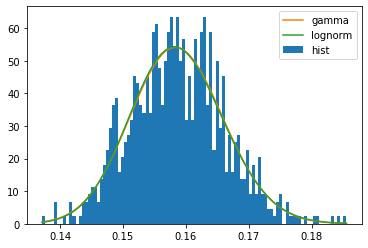

19 6
0.0
0.0


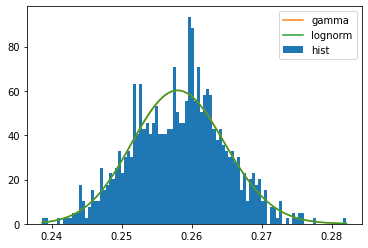

19 7
0.0
0.0


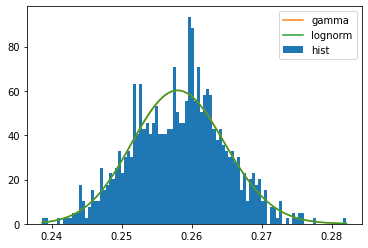

19 8
0.0
0.0


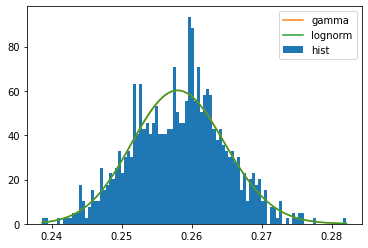

19 9
0.0
0.0


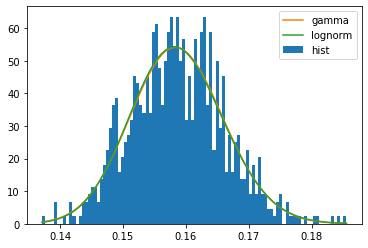

19 10
0.0
0.0


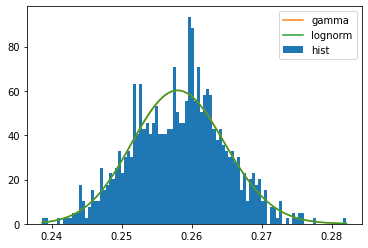

19 11
0.0
0.0


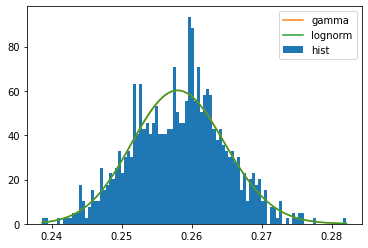

19 12
0.0
0.0


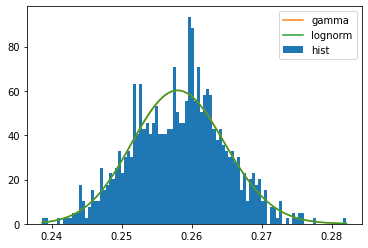

19 13
0.0
0.0


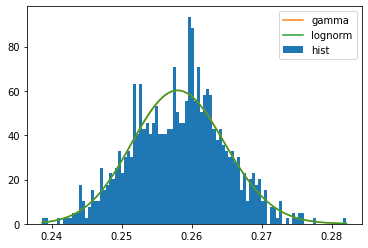

19 14
0.0
0.0


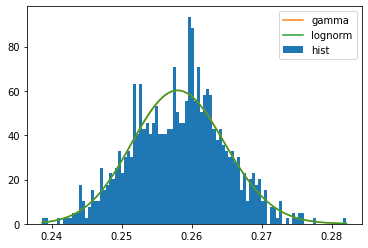

19 15
0.0
0.0


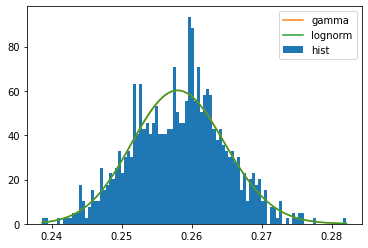

19 16
0.0
0.0


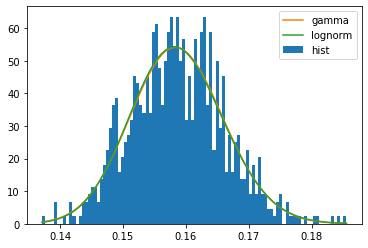

19 17
0.0
0.0


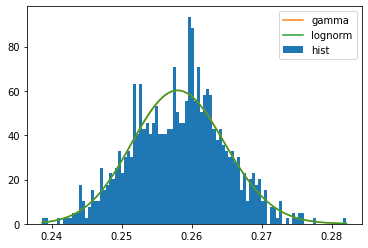

19 18
0.0
0.0


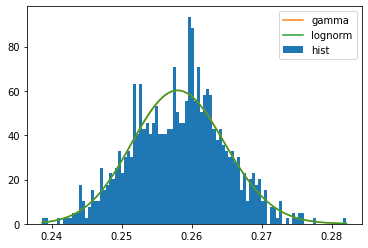

20 0
0.0
0.0


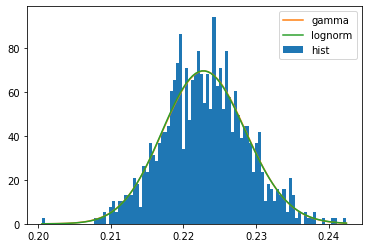

20 1
0.0
0.0


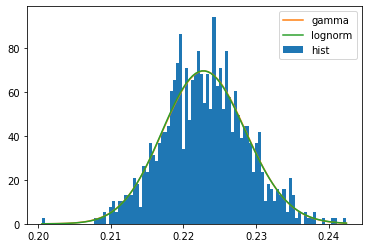

20 2
0.0
0.0


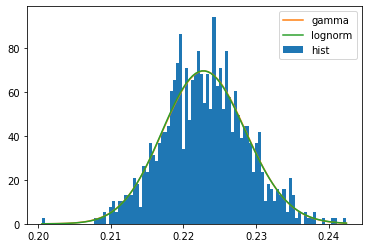

20 3
0.0
0.0


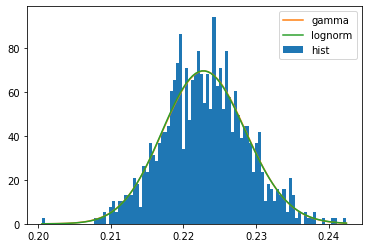

20 4
0.0
0.0


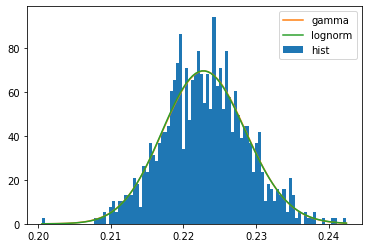

20 5
0.0
0.0


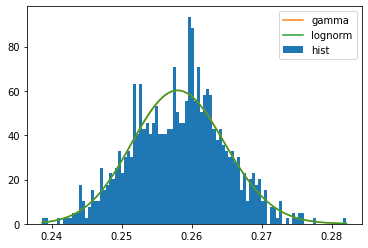

20 6
0.0
0.0


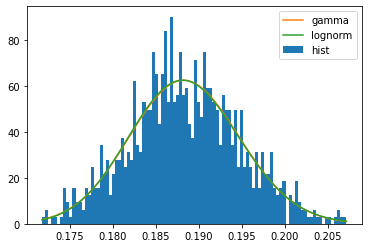

20 7
0.0
0.0


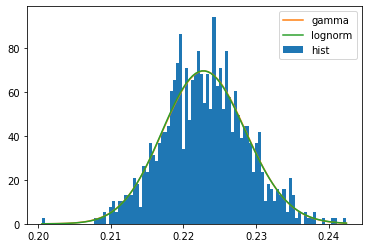

20 8
0.0
0.0


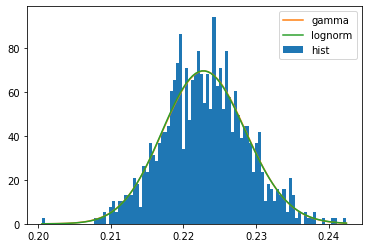

20 9
0.0
0.0


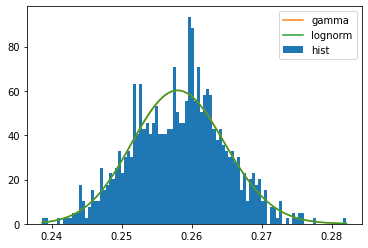

20 10
0.0
0.0


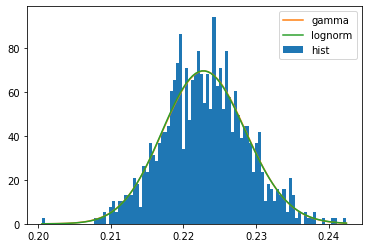

20 11
0.0
0.0


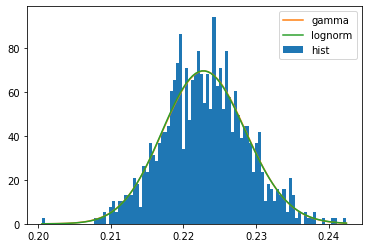

20 12
0.0
0.0


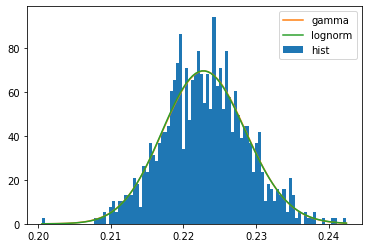

20 13
0.0
0.0


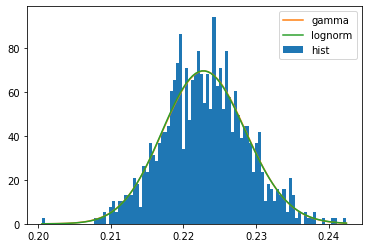

20 14
0.0
0.0


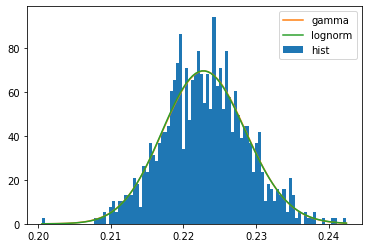

20 15
0.0
0.0


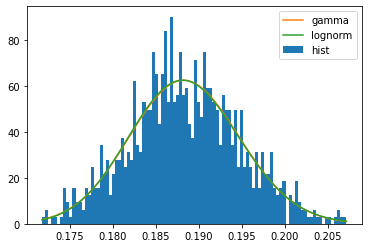

20 16
0.0
0.0


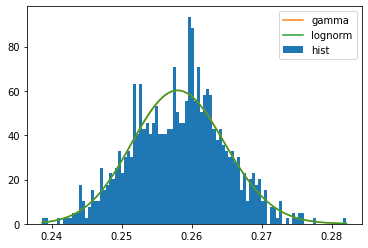

20 17
0.0
0.0


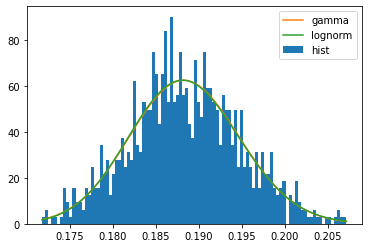

20 18
0.0
0.0


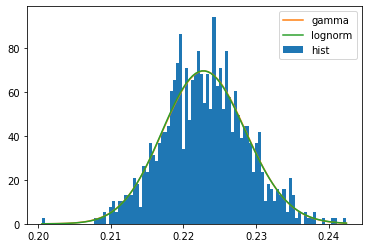

20 19
0.0
0.0


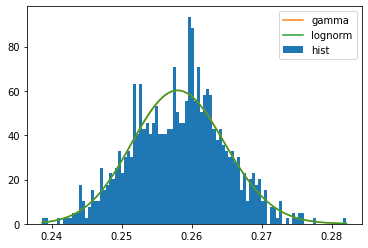

21 0
0.0
0.0


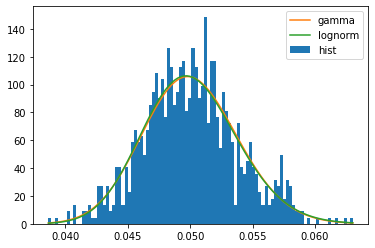

21 1
0.0
0.0


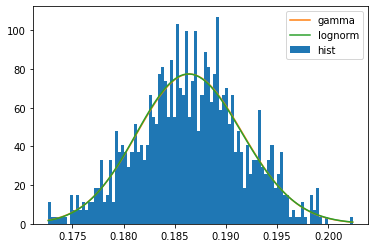

21 2
0.0
0.0


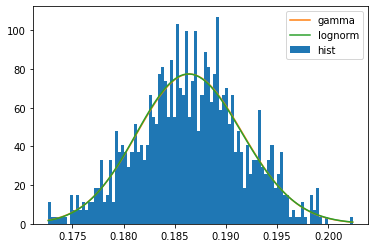

21 3
0.0
0.0


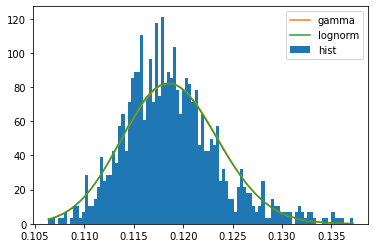

21 4
0.0
0.0


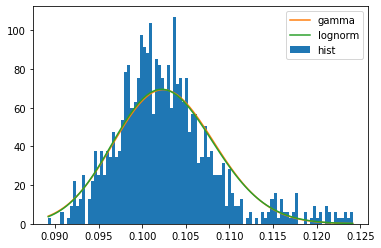

21 5
0.0
0.0


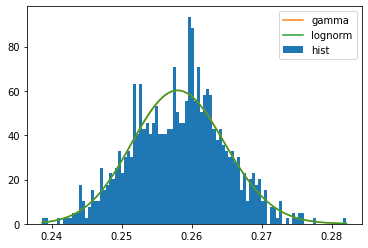

21 6
0.0
0.0


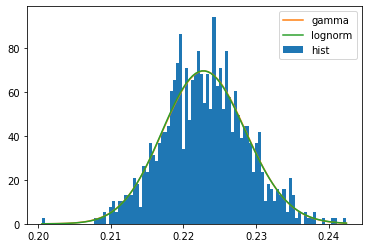

21 7
0.0
0.0


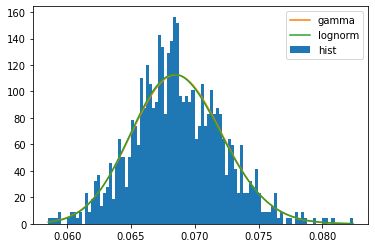

21 8
0.0
0.0


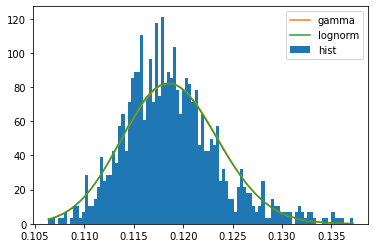

21 9
0.0
0.0


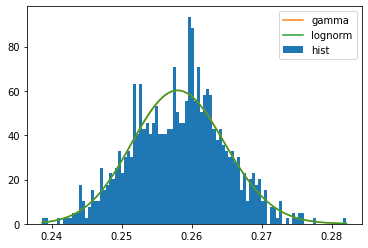

21 10
0.0
0.0


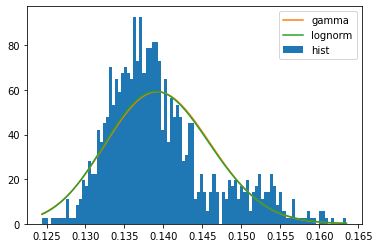

21 11
0.0
0.0


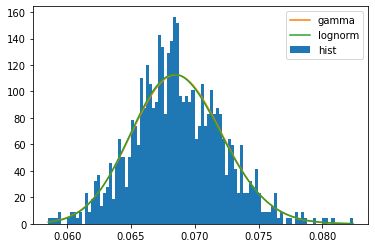

21 12
0.0
0.0


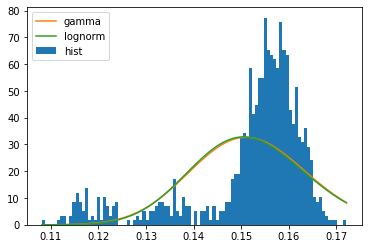

21 13
0.0
0.0


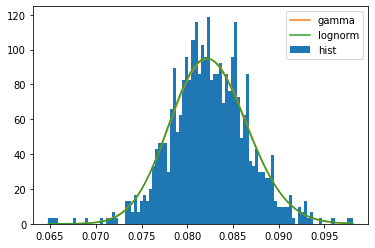

21 14
0.0
0.0


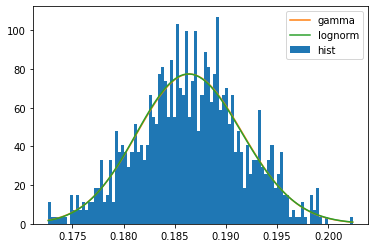

21 15
0.0
0.0


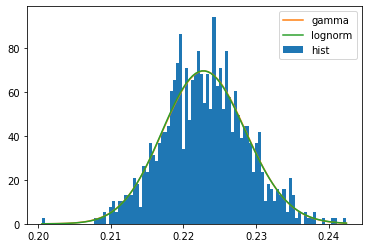

21 16
0.0
0.0


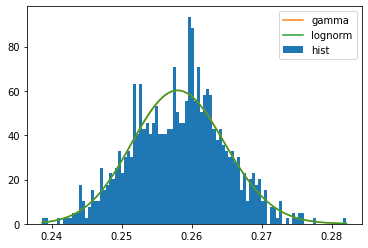

21 17
0.0
0.0


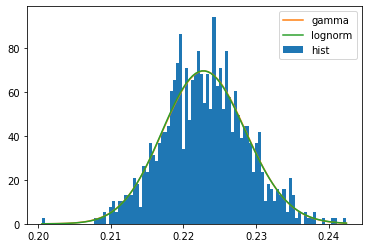

21 18
0.0
0.0


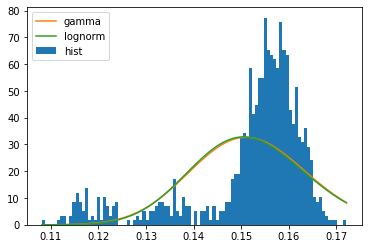

21 19
0.0
0.0


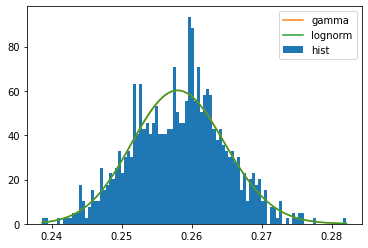

21 20
0.0
0.0


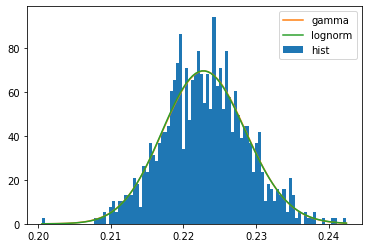

22 0
0.0
0.0


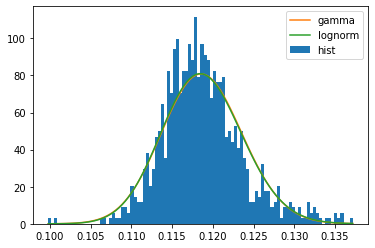

22 1
0.0
0.0


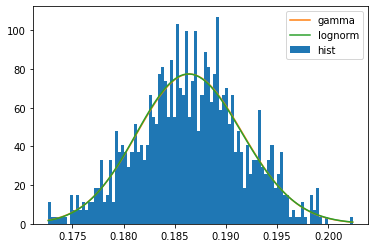

22 2
0.0
0.0


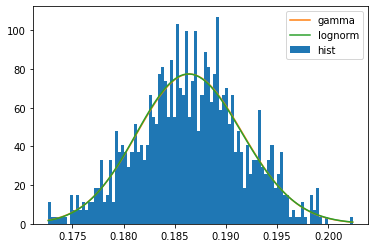

22 3
0.0
0.0


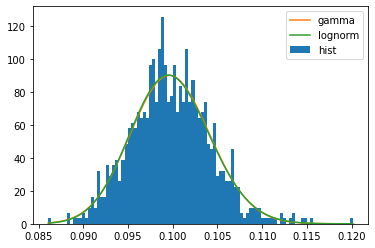

22 4
0.0
0.0


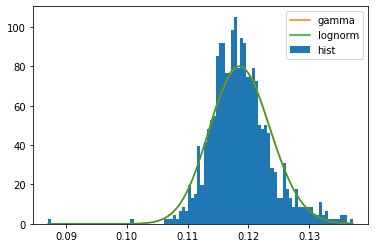

22 5
0.0
0.0


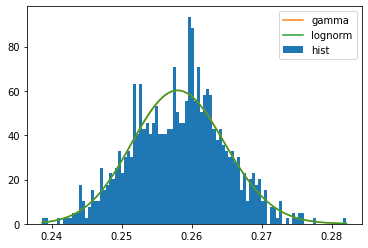

22 6
0.0
0.0


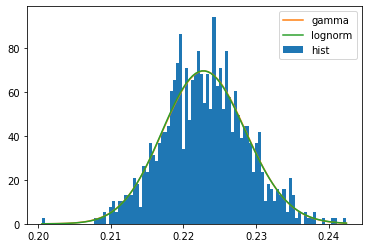

22 7
0.0
0.0


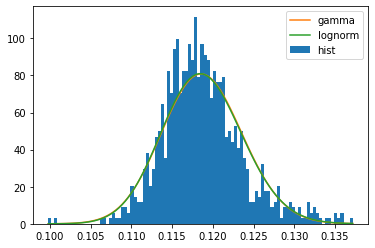

22 8
0.0
0.0


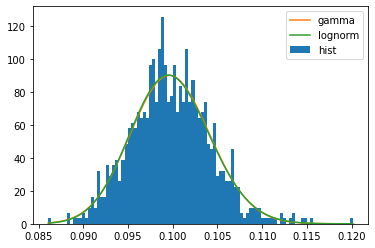

22 9
0.0
0.0


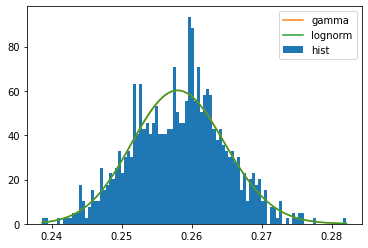

22 10
0.0
0.0


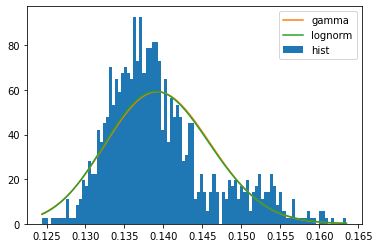

22 11
0.0
0.0


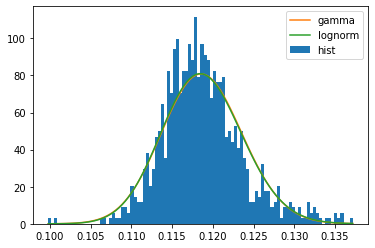

22 12
0.0
0.0


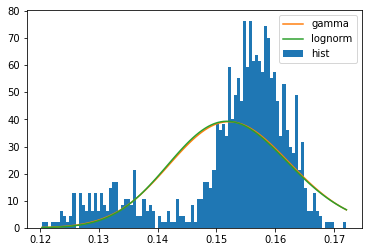

22 13
0.0
0.0


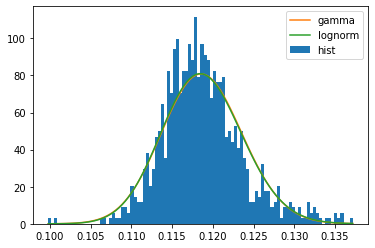

22 14
0.0
0.0


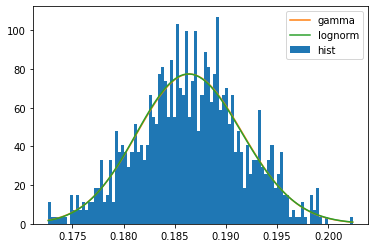

22 15
0.0
0.0


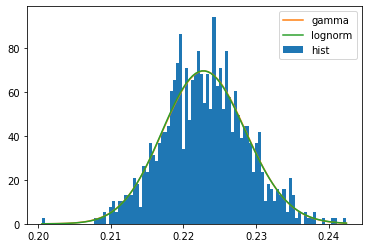

22 16
0.0
0.0


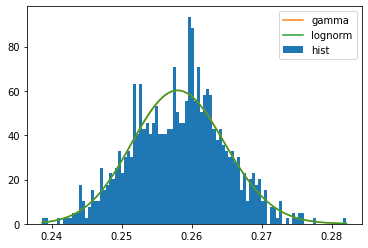

22 17
0.0
0.0


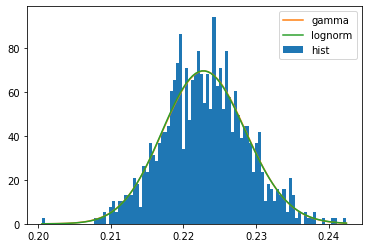

22 18
0.0
0.0


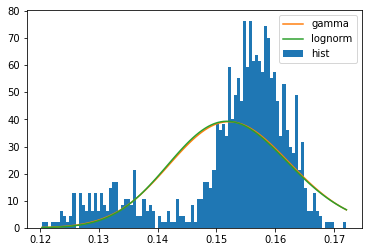

22 19
0.0
0.0


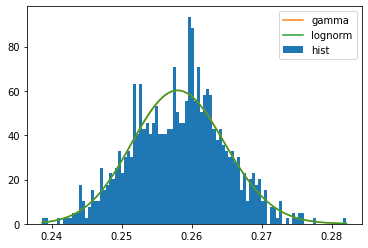

22 20
0.0
0.0


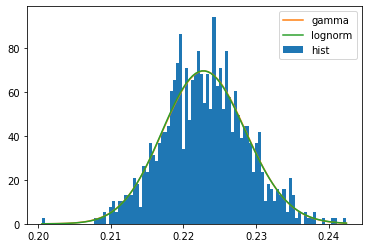

22 21
0.0
0.0


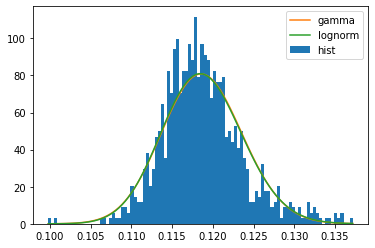

23 0
0.0
0.0


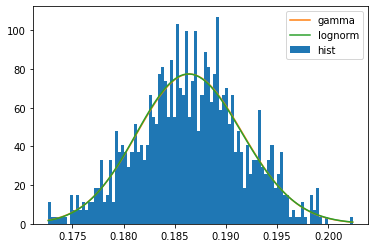

23 1
0.0
0.0


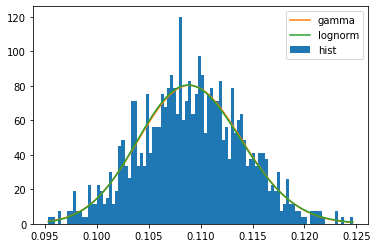

23 2
0.0
0.0


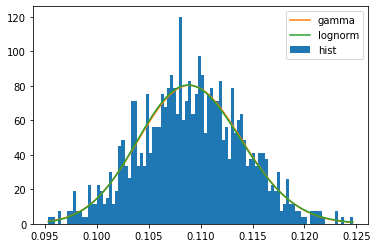

23 3
0.0
0.0


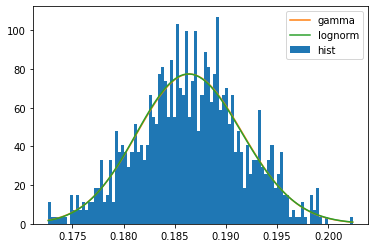

23 4
0.0
0.0


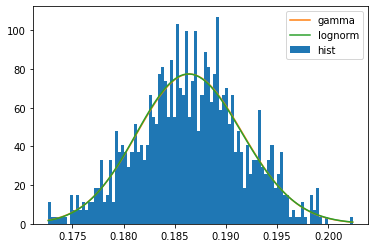

23 5
0.0
0.0


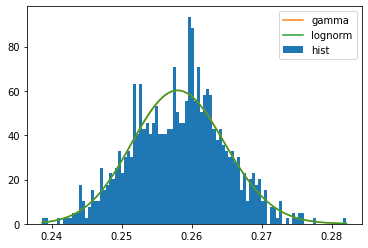

23 6
0.0
0.0


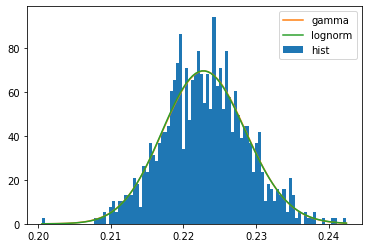

23 7
0.0
0.0


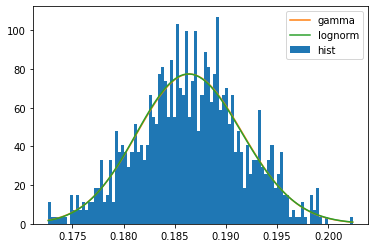

23 8
0.0
0.0


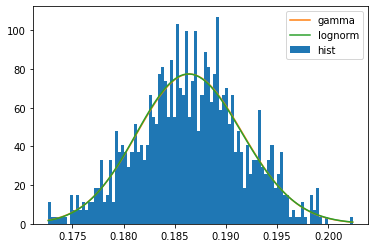

23 9
0.0
0.0


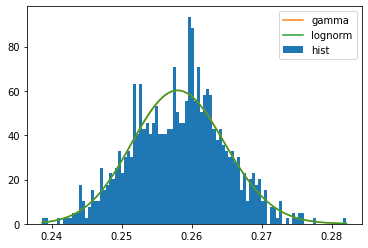

23 10
0.0
0.0


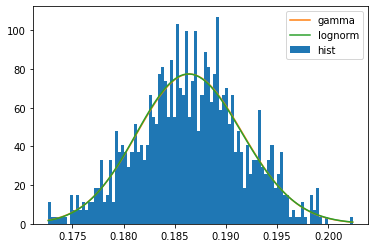

23 11
0.0
0.0


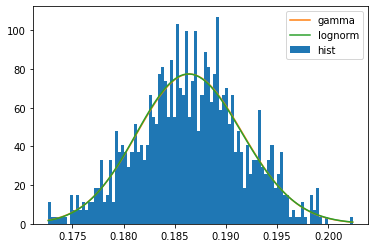

23 12
0.0
0.0


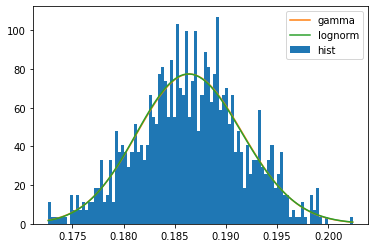

23 13
0.0
0.0


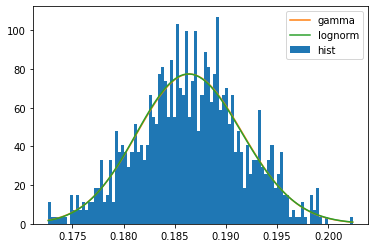

23 14
0.0
0.0


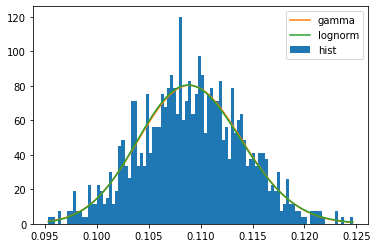

23 15
0.0
0.0


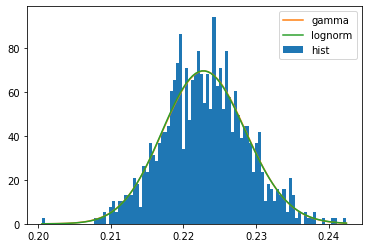

23 16
0.0
0.0


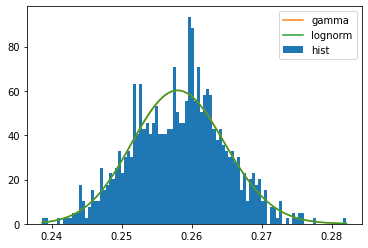

23 17
0.0
0.0


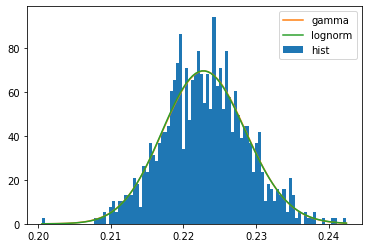

23 18
0.0
0.0


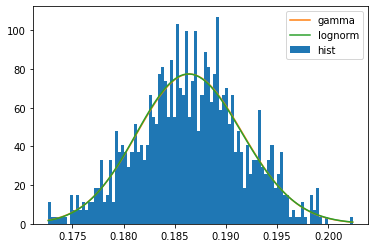

23 19
0.0
0.0


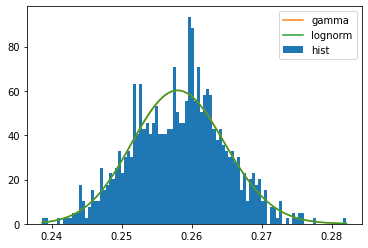

23 20
0.0
0.0


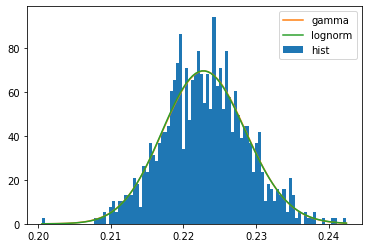

23 21
0.0
0.0


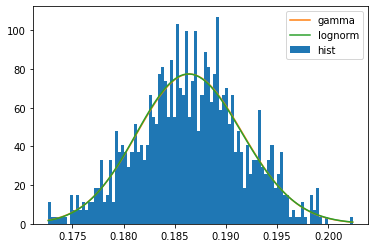

23 22
0.0
0.0


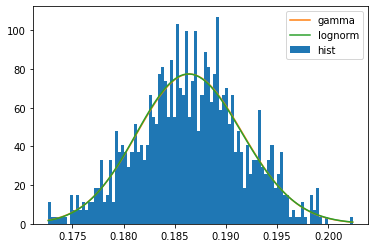

24 0
0.0
0.0


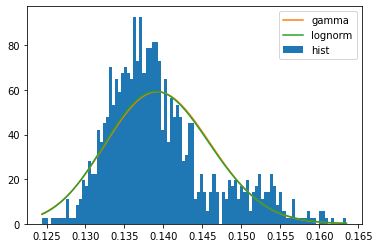

24 1
0.0
0.0


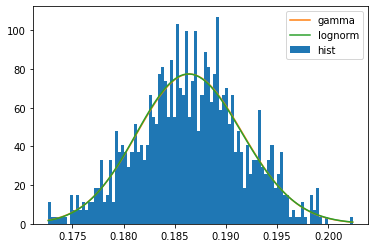

24 2
0.0
0.0


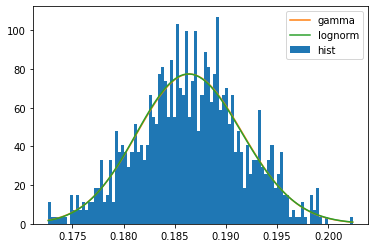

24 3
0.0
0.0


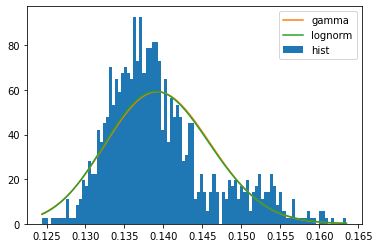

24 4
0.0
0.0


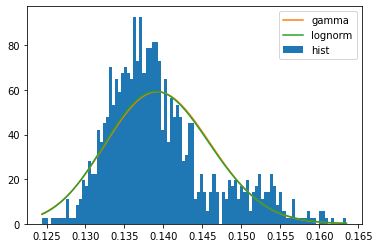

24 5
0.0
0.0


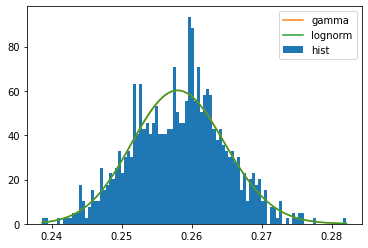

24 6
0.0
0.0


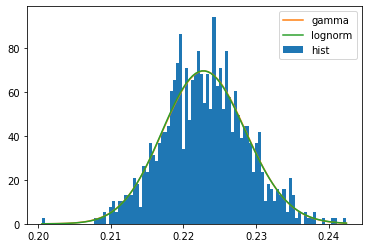

24 7
0.0
0.0


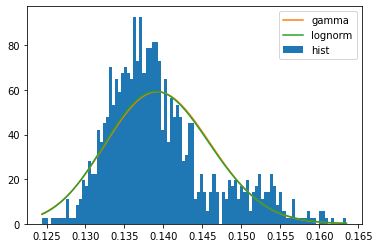

24 8
0.0
0.0


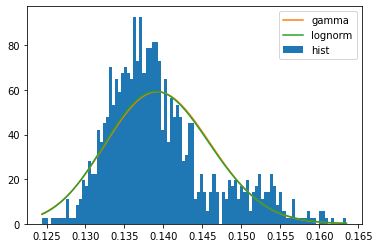

24 9
0.0
0.0


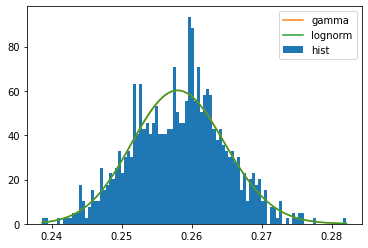

24 10
0.0
0.0


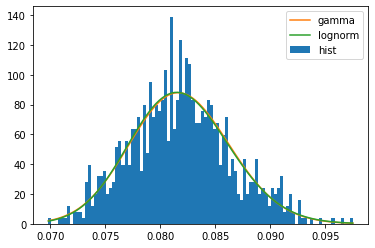

24 11
0.0
0.0


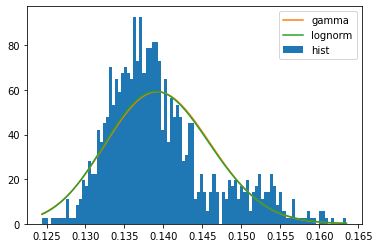

24 12
0.0
0.0


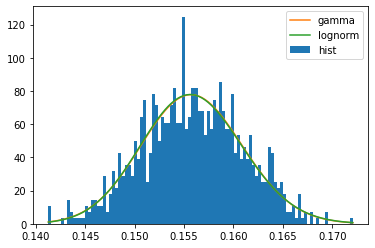

24 13
0.0
0.0


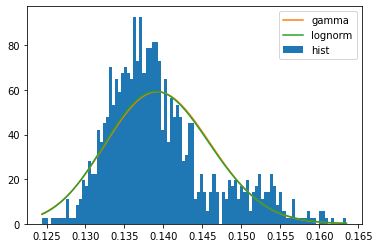

24 14
0.0
0.0


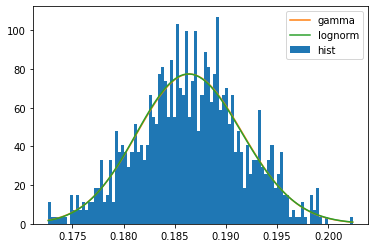

24 15
0.0
0.0


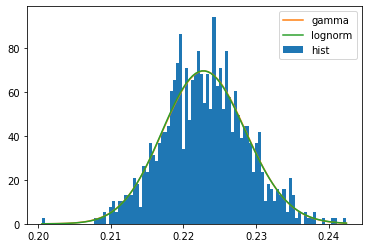

24 16
0.0
0.0


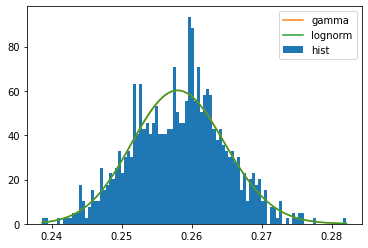

24 17
0.0
0.0


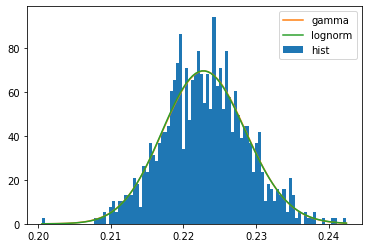

24 18
0.0
0.0


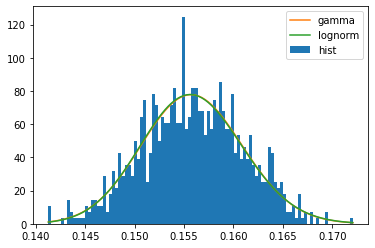

24 19
0.0
0.0


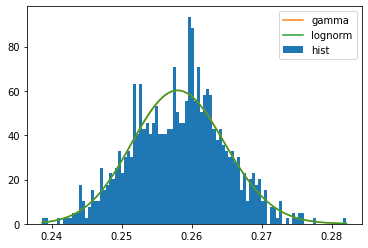

24 20
0.0
0.0


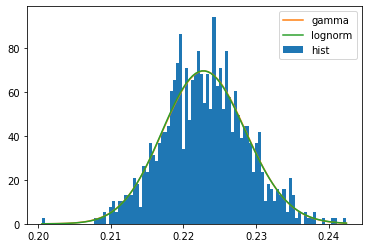

24 21
0.0
0.0


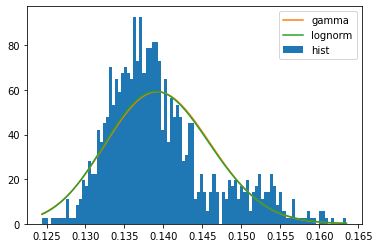

24 22
0.0
0.0


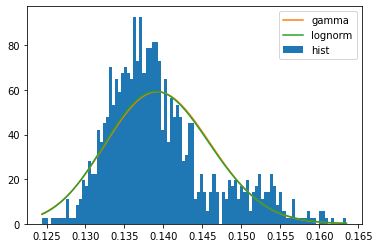

24 23
0.0
0.0


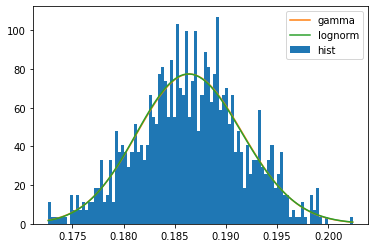

25 0
0.0
0.0


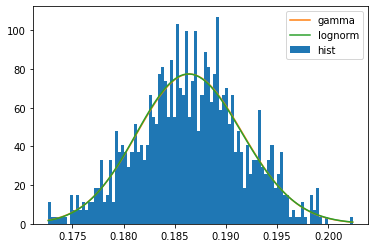

25 1
0.0
0.0


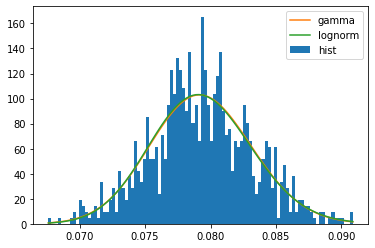

25 2
0.0
0.0


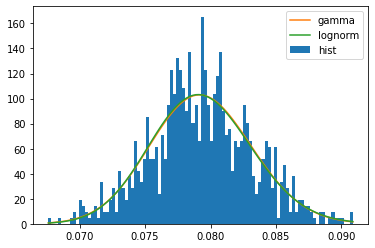

25 3
0.0
0.0


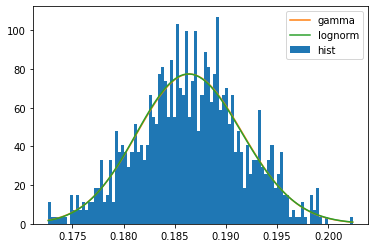

25 4
0.0
0.0


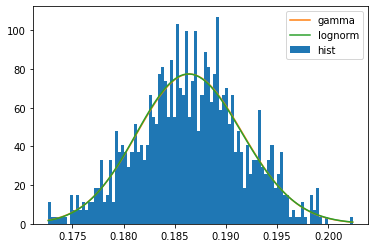

25 5
0.0
0.0


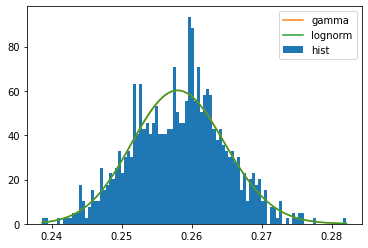

25 6
0.0
0.0


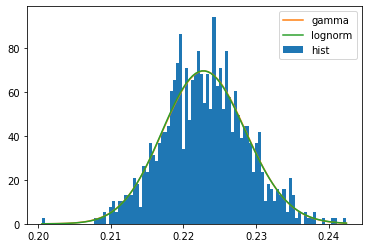

25 7
0.0
0.0


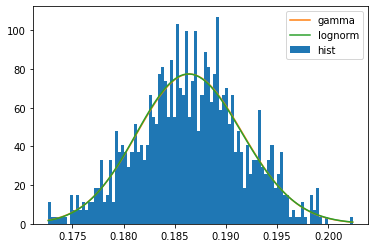

25 8
0.0
0.0


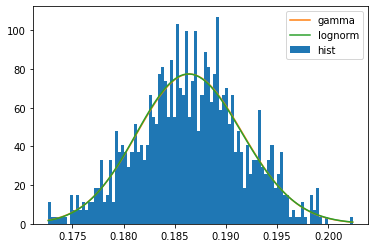

25 9
0.0
0.0


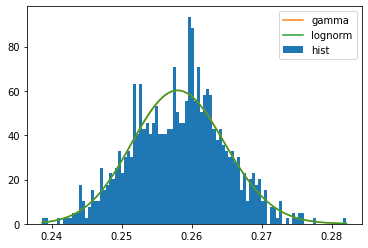

25 10
0.0
0.0


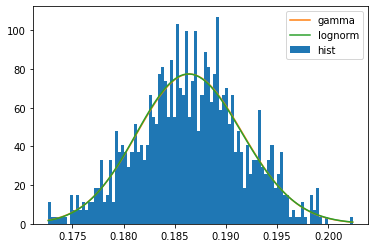

25 11
0.0
0.0


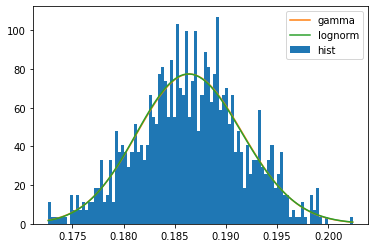

25 12
0.0
0.0


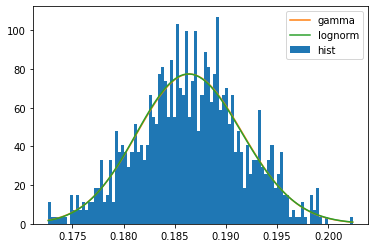

25 13
0.0
0.0


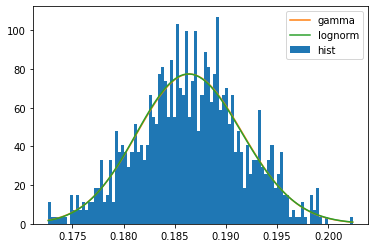

25 14
0.0
0.0


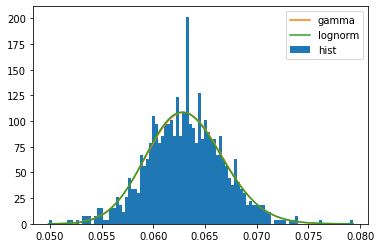

25 15
0.0
0.0


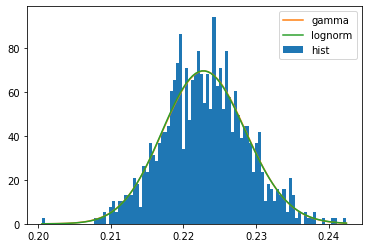

25 16
0.0
0.0


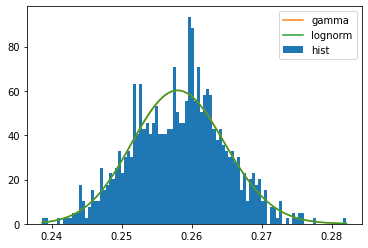

25 17
0.0
0.0


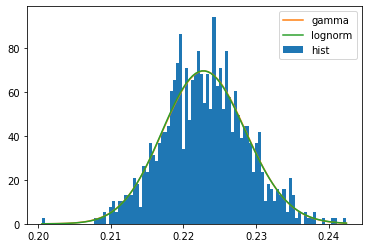

25 18
0.0
0.0


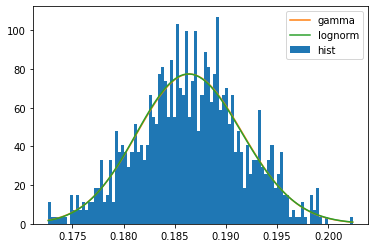

25 19
0.0
0.0


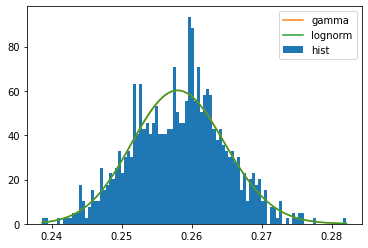

25 20
0.0
0.0


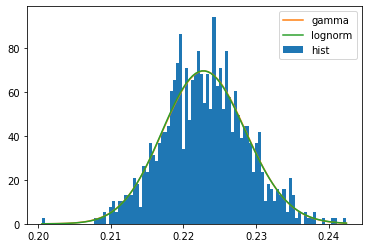

25 21
0.0
0.0


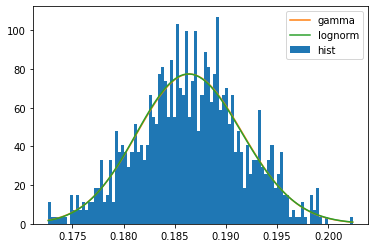

25 22
0.0
0.0


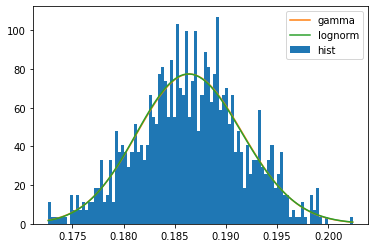

25 23
0.0
0.0


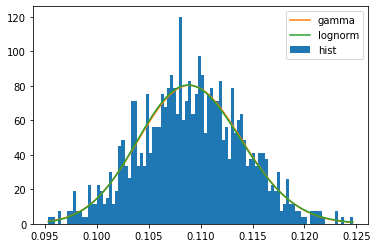

25 24
0.0
0.0


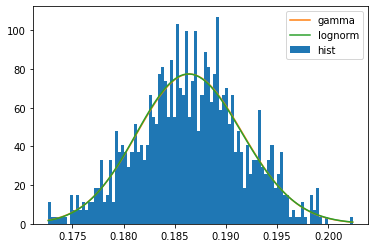

26 0
0.0
0.0


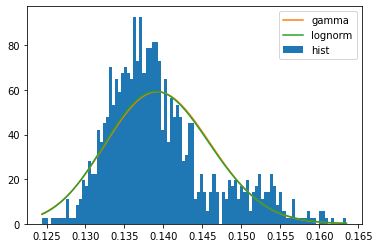

26 1
0.0
0.0


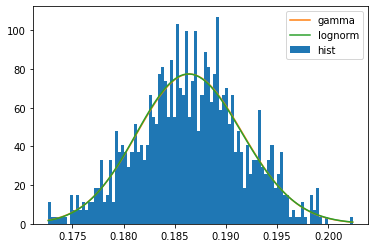

26 2
0.0
0.0


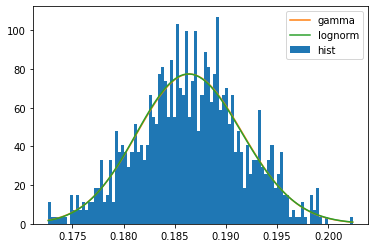

26 3
0.0
0.0


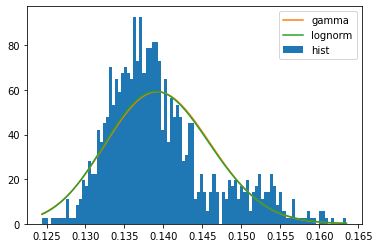

26 4
0.0
0.0


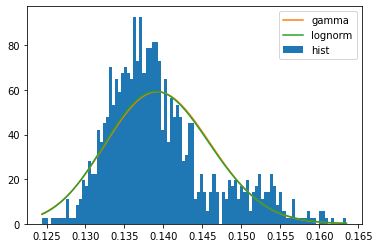

26 5
0.0
0.0


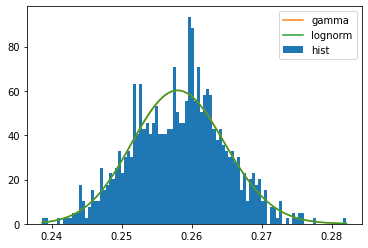

26 6
0.0
0.0


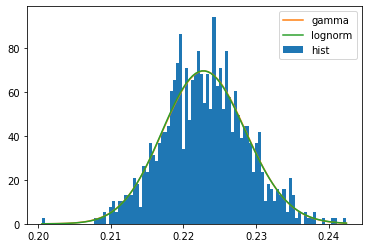

26 7
0.0
0.0


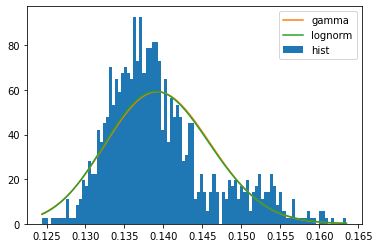

26 8
0.0
0.0


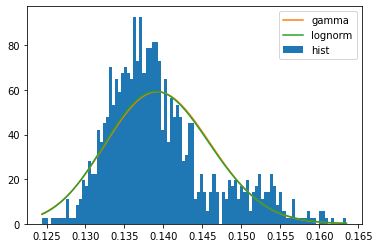

26 9
0.0
0.0


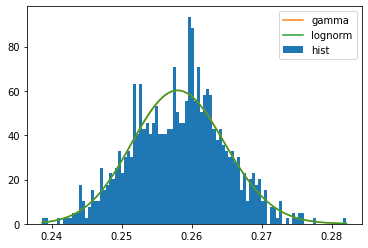

26 10
0.0
0.0


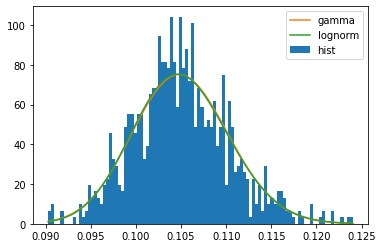

26 11
0.0
0.0


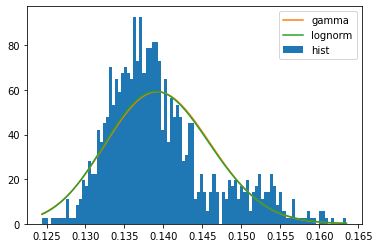

26 12
0.0
0.0


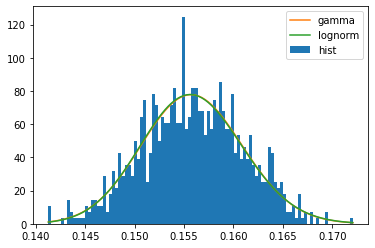

26 13
0.0
0.0


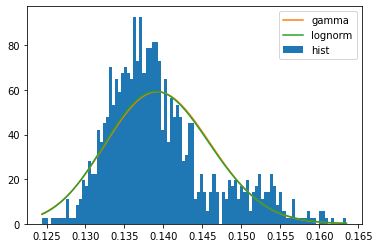

26 14
0.0
0.0


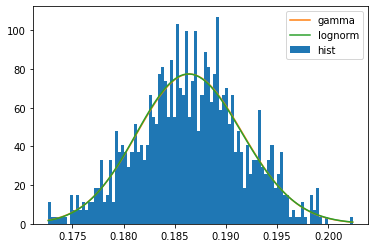

26 15
0.0
0.0


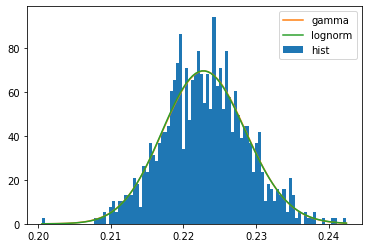

26 16
0.0
0.0


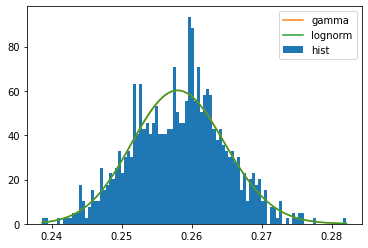

26 17
0.0
0.0


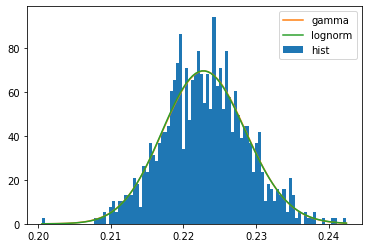

26 18
0.0
0.0


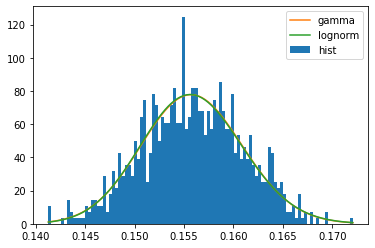

26 19
0.0
0.0


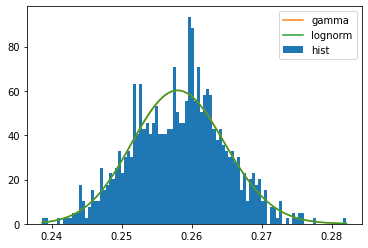

26 20
0.0
0.0


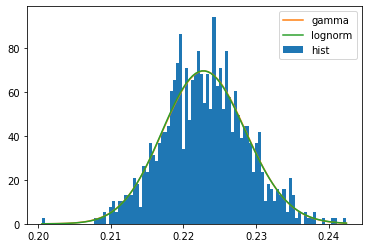

26 21
0.0
0.0


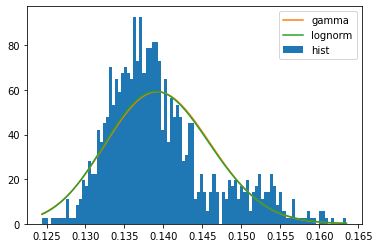

26 22
0.0
0.0


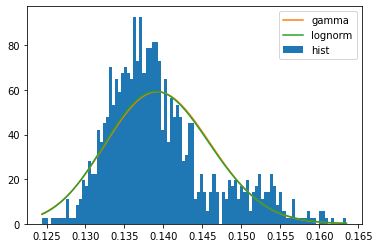

26 23
0.0
0.0


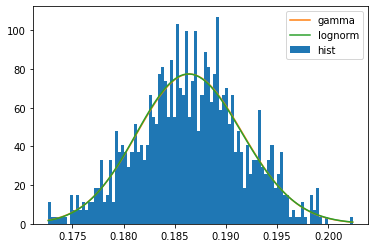

26 24
0.0
0.0


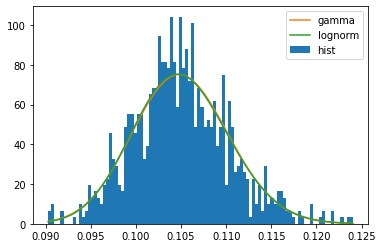

26 25
0.0
0.0


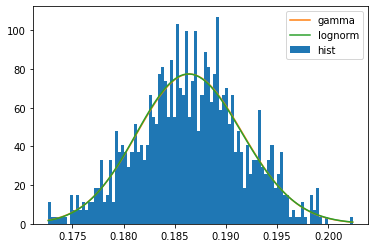

27 0
0.0
0.0


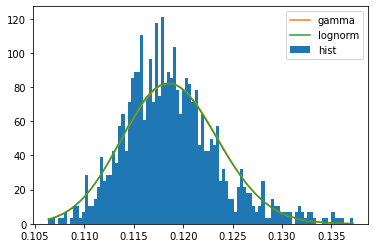

27 1
0.0
0.0


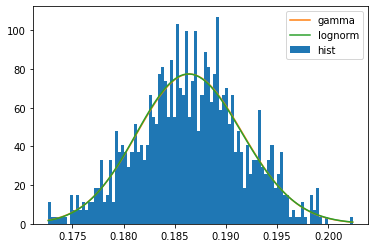

27 2
0.0
0.0


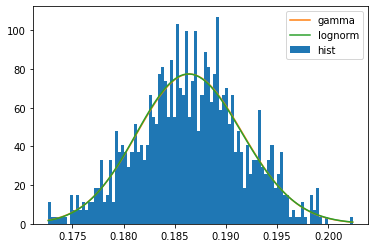

27 3
0.0
0.0


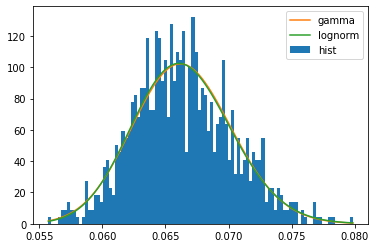

27 4
0.0
0.0


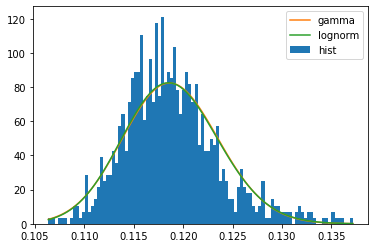

27 5
0.0
0.0


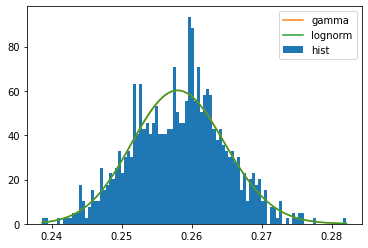

27 6
0.0
0.0


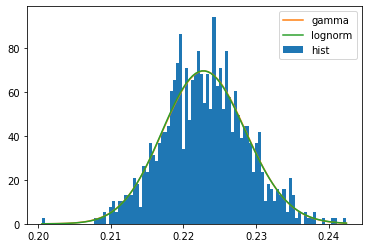

27 7
0.0
0.0


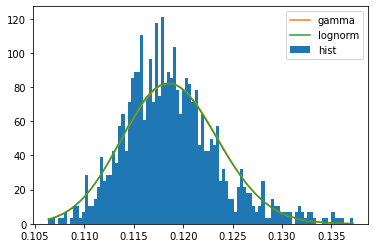

27 8
0.0
0.0


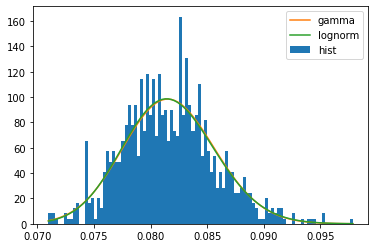

27 9
0.0
0.0


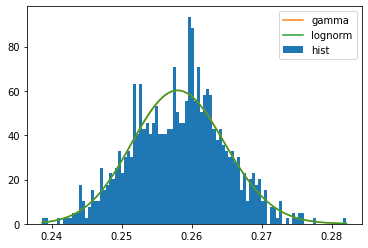

27 10
0.0
0.0


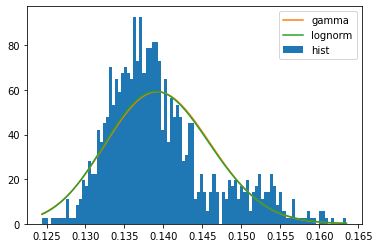

27 11
0.0
0.0


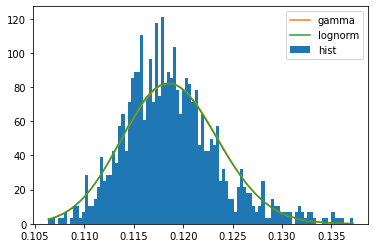

27 12
0.0
0.0


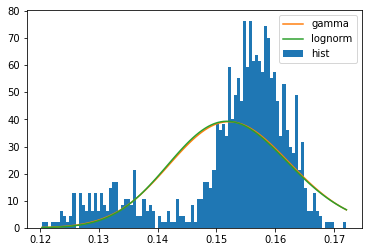

27 13
0.0
0.0


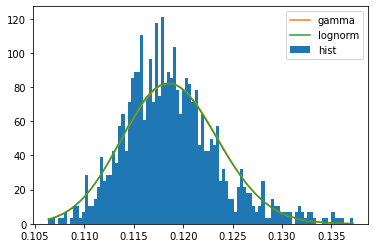

27 14
0.0
0.0


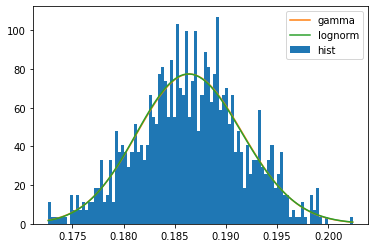

27 15
0.0
0.0


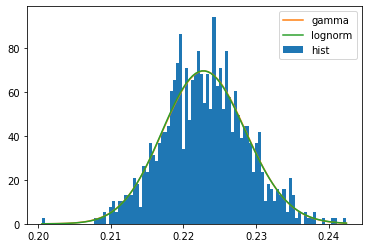

27 16
0.0
0.0


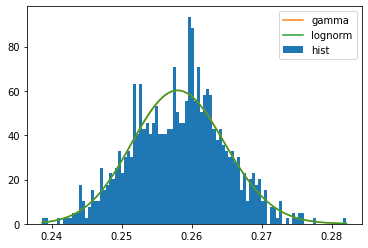

27 17
0.0
0.0


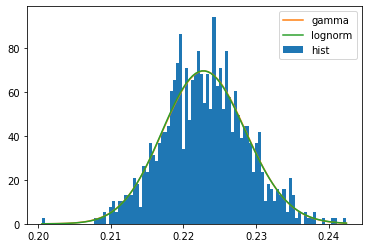

27 18
0.0
0.0


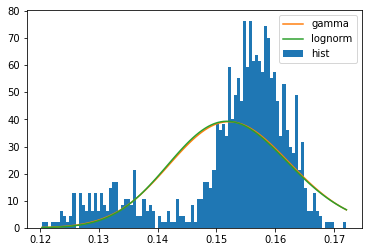

27 19
0.0
0.0


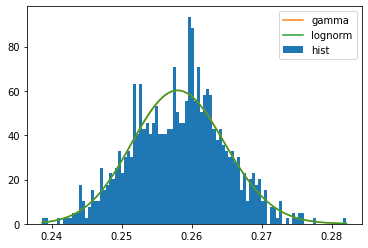

27 20
0.0
0.0


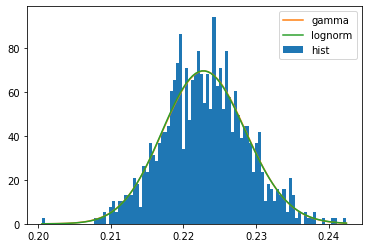

27 21
0.0
0.0


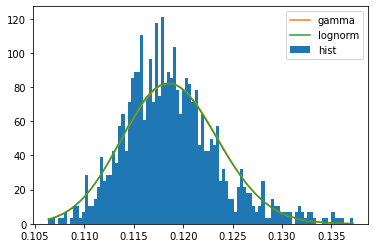

27 22
0.0
0.0


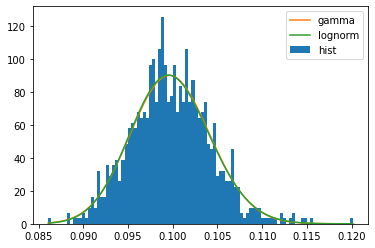

27 23
0.0
0.0


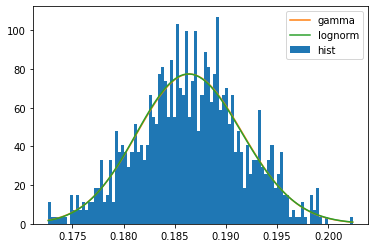

27 24
0.0
0.0


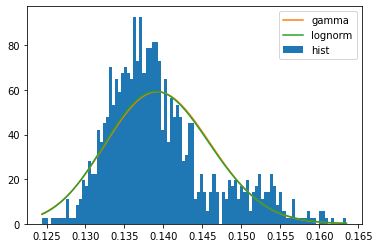

27 25
0.0
0.0


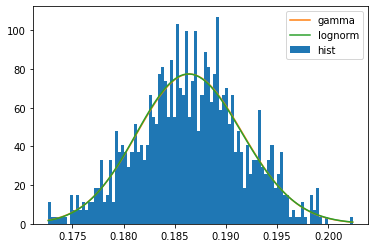

27 26
0.0
0.0


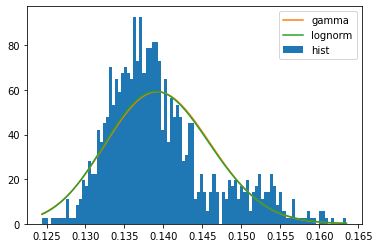

28 0
0.0
0.0


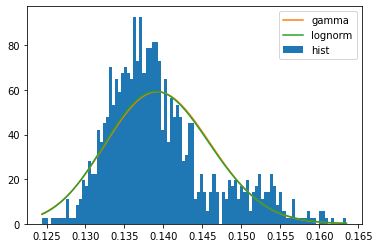

28 1
0.0
0.0


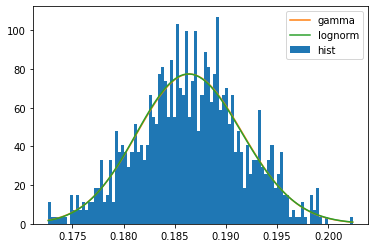

28 2
0.0
0.0


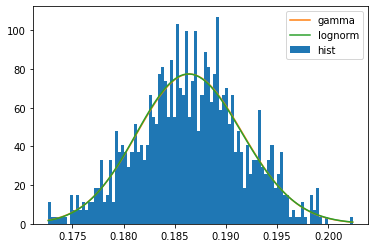

28 3
0.0
0.0


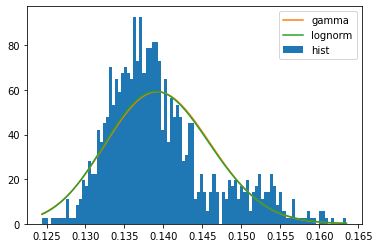

28 4
0.0
0.0


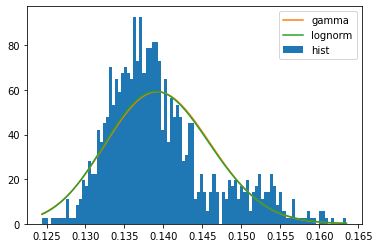

28 5
0.0
0.0


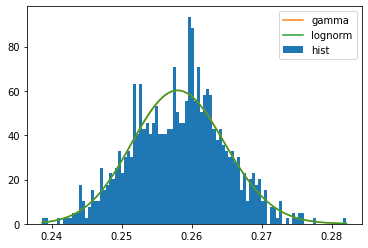

28 6
0.0
0.0


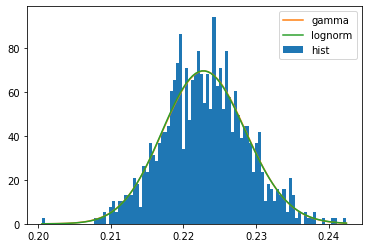

28 7
0.0
0.0


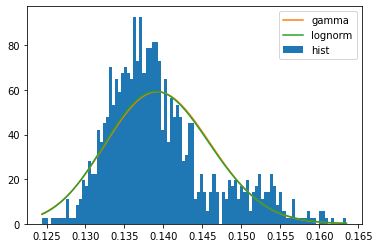

28 8
0.0
0.0


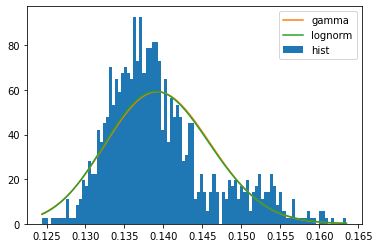

28 9
0.0
0.0


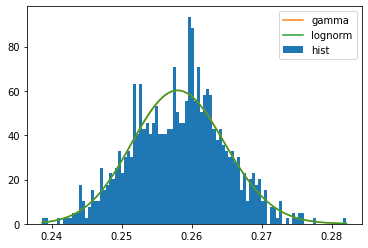

28 10
0.0
0.0


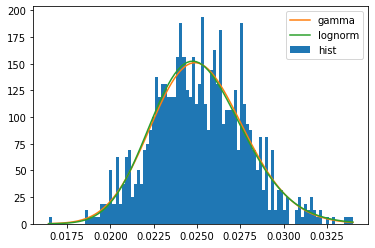

28 11
0.0
0.0


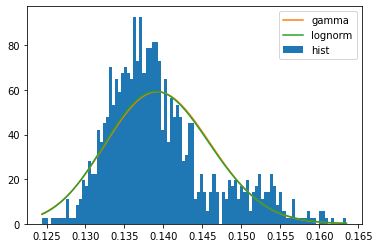

28 12
0.0
0.0


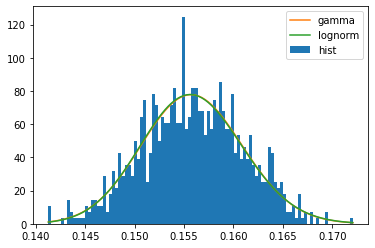

28 13
0.0
0.0


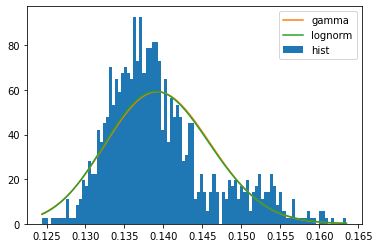

28 14
0.0
0.0


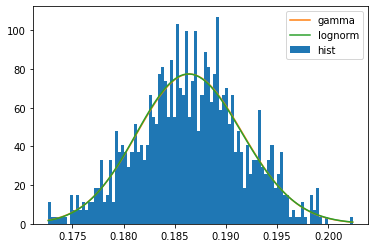

28 15
0.0
0.0


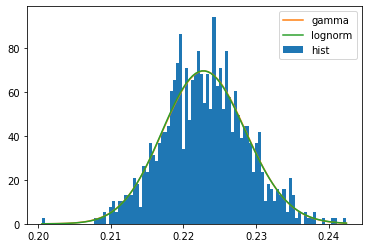

28 16
0.0
0.0


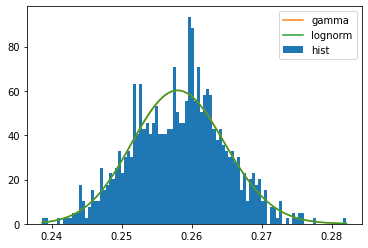

28 17
0.0
0.0


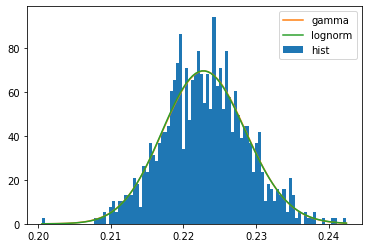

28 18
0.0
0.0


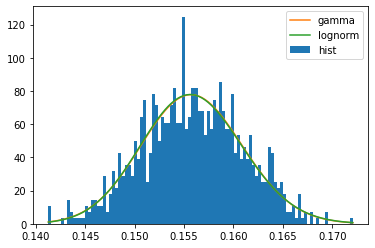

28 19
0.0
0.0


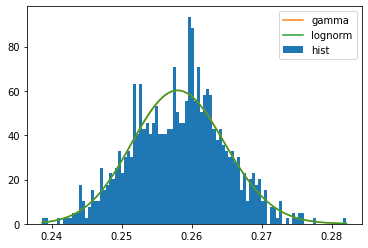

28 20
0.0
0.0


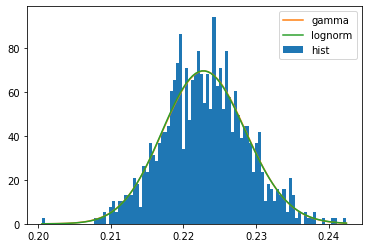

28 21
0.0
0.0


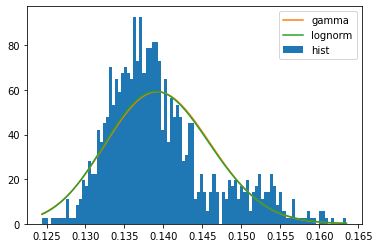

28 22
0.0
0.0


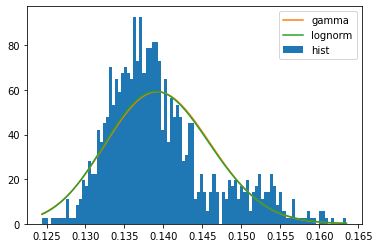

28 23
0.0
0.0


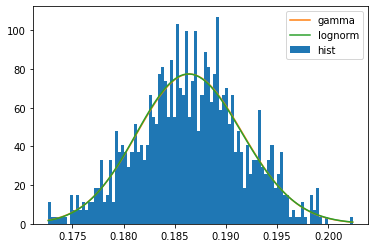

28 24
0.0
0.0


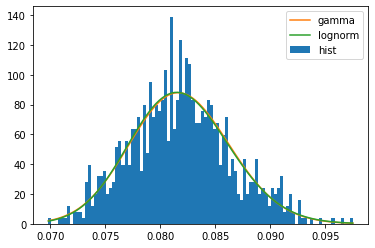

28 25
0.0
0.0


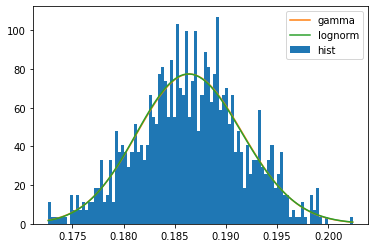

28 26
0.0
0.0


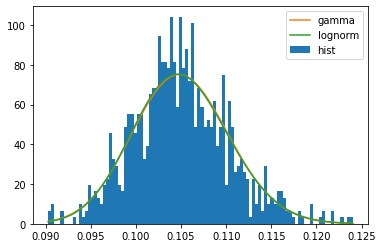

28 27
0.0
0.0


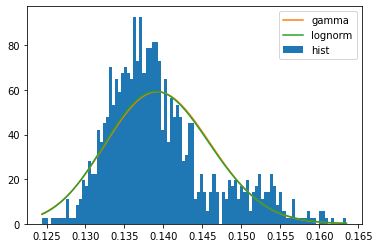

In [31]:
from scipy.stats import gamma
from scipy.stats import lognorm

for j in range(ntaxa):
    for k in range(j):
        print(j,k)
        print(np.mean([(x != y) and (x in ["c","a","g","t"]) and (y in ["c","a","g","t"]) for x,y in zip(genomes[j],genomes[k])]))
        print(np.mean([(x == y) and (x in ["c","a","g","t"]) and (y in ["c","a","g","t"]) for x,y in zip(genomes[j],genomes[k])]))
        vals = dists[:,j,k]
        mean = np.mean(vals)
        std = np.std(vals)
        
        sigma = np.sqrt(np.log(1 + (std / mean) ** 2))
        mu = np.log(mean) - 0.5 * sigma**2
        
        alpha = (mean / std) ** 2
        beta = std ** 2 / mean
        
        xs = np.linspace(min(vals),max(vals),100)
        y1s = gamma.pdf(xs, a=alpha, scale=beta)
        y2s = lognorm.pdf(xs, s=sigma, scale=np.exp(mu))
        
        plt.hist(dists[:,j,k],bins=100,density=True)
        plt.plot(xs,y1s)
        plt.plot(xs,y2s)
        plt.legend(["gamma","lognorm","hist"])
        plt.show()

In [17]:
for j in range(ntaxa):
    for k in range(j-1,j):
        sum([(x != y) and (x in ["c","a","g","t"]) and (y in ["c","a","g","t"]) for x,y in zip(genomes[62],genomes[63])])

19

In [13]:
genomes[62]

'----------------------------------------cagttgttaattatcctcccccccttctgcctgagccatggacatnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnttatttnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnncattnnnnaagaagctaaaaaggtaaaaccaacattggttgttaatgcagccaatgtttaccttaaacatggaggaggtgttgcaggagccttaaataaggctactaacaatgccatgcaagttgaatnnnnnnnnnnnnnnnnccgctcatcggctcgccatctcacttgctggttcctataaagattggtcctattctggacaatctacacaactaggtatagaatttcttaagagaggtgataaaagtgtatattacactagattaacctccacatgtcaatgacatatggacaacagtttggtccaacttatttggtccctcgcccccgcctgccgcactcccatcttttaaatgggatttaactgcttttggcttagttgcagagtggtttttggcatatattcttttcactaggtttttctatgtacttggattggctgcaatcatgcaattgtttttcagctattttgcagtacattttattagtaattcttggcttatgtggttaataattaatctgttgtaattcnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

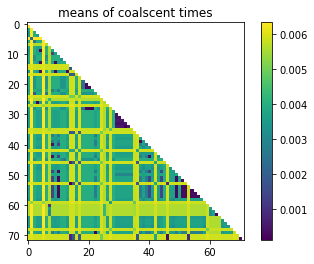

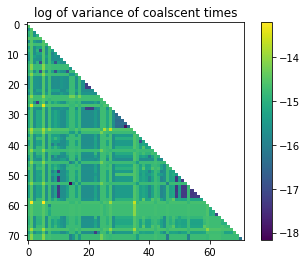

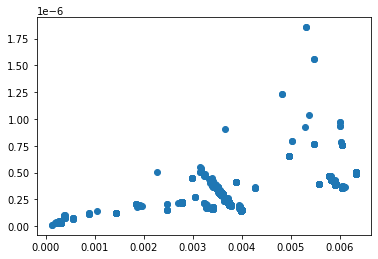

In [11]:
# plot theta0
m = deepcopy(theta0[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)#,vmin = -10, vmax = -4)
plt.title("means of coalscent times")
plt.colorbar()
plt.show()

var = deepcopy(theta0[1])
var[np.triu_indices(var.shape[0])] = np.nan
plt.imshow(np.log(var))#,vmin=-4,vmax=1)
plt.title("log of variance of coalscent times")
plt.colorbar()
plt.show()

plt.scatter(m.flatten(),var.flatten())

In [458]:
from VIPR import VIPR
optim = VIPR(genomes,theta0[0],theta0[1],
             pop_size,var_dist="LogNormal")

In [459]:
# keep fixed values
decay = "exp"
batch_size = 10
max_iters = 1000#200000
record_every = 100
test_batch_size = 100
if decay == "linear":
    linear_decay = True
else:
    linear_decay = False
anneal_freq = 1
anneal_rate = 0.1**(1.0/max_iters)
pop_size = 5.0
max_time = 2.0 # HOURS

alpha = 0.1

optim.learn(batch_size=batch_size,
            iters=max_iters,
            alpha=alpha,
            method="reinforce",
            record_every=record_every,
            test_batch_size=test_batch_size,
            pop_size=pop_size,
            anneal_freq=anneal_freq,
            anneal_rate=anneal_rate,
            linear_decay=linear_decay,
            max_time=max_time)

iteration 0:(0.5s)
step size:  0.1
grad_norm estimate:  1152.1991
ELBO estimate:  -11503.121783337472
100-sample ELBO estimate:  -11321.197265625

tensor([[-6.5555],
        [-0.7630]], grad_fn=<IndexBackward0>)
tensor(0.0012, dtype=torch.float64)


ValueError: Error in cdf or pdf calculation

In [ ]:
# plot theta
m = deepcopy(optim.theta[0].detach().numpy())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)#,vmin = -10, vmax = -4)
plt.title("means of log coalscent times")
plt.colorbar()
plt.show()

var = deepcopy(optim.theta[1].detach().numpy())
var[np.triu_indices(var.shape[0])] = np.nan
plt.imshow(var)#,vmin=-4,vmax=1)
plt.title("log of variance of log coalscent times")
plt.colorbar()
plt.show()

plt.scatter(m.flatten(),np.log(var.flatten()))

In [ ]:
# my models
optims = {}
settings = {}
ELBO_star = -np.infty
fname_star = None
ELBO_min = np.infty
ELBO_max = -np.infty

for model in ["reinforce","reparam","VIMCO"]:
    
    optims[model] = None
    ELBO_star = -np.infty
    
    for ss in [0.03,0.01,0.003,0.001]:
    
        for rs in range(5):
            
            optim_dir = '../results/'+dataset+'/'
            optim_pref = dataset+'_'+model+'_'+str(ss)+'_'+str(rs)
            files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
            
            files = [x for x in files if "2025_02" in x]

            if not files:
                print(optim_pref + " does not exist. Continuing...")
                continue
            
            fname = optim_dir + max(files)
    
            with open(fname, 'rb') as f:
                optim0 = pickle.load(f)
            
            if np.mean(optim0.multi_ELBO_ests[-10:]) > ELBO_star:
                optims[model] = optim0
                settings[model] = (ss,rs)
                ELBO_star = np.mean(optim0.multi_ELBO_ests[-10:])
                fname_star = fname
                
    print(fname_star)
    
    if max(optims[model].multi_ELBO_ests) > ELBO_max:
        ELBO_max = max(optims[model].multi_ELBO_ests)

    if min(optims[model].multi_ELBO_ests) < ELBO_min:
        ELBO_min = min(optims[model].multi_ELBO_ests)

In [ ]:
for theta in [optims["reparam"].theta,
              optims["reinforce"].theta,
              optims["VIMCO"].theta]:
    
    m = deepcopy(theta[0].detach())
    m[np.triu_indices(m.shape[0])] = np.nan
    plt.imshow(m,vmin = -10, vmax = -4)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()
    
    plt.imshow(deepcopy(theta0[0]),vmin = -10, vmax = -4)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()
    
    plt.imshow(m - theta0[0])
    plt.colorbar()
    plt.show()

    log_sig = deepcopy(theta[1].detach())
    log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
    plt.imshow(log_sig,vmin = -4, vmax = 1)
    plt.title("log-std of log-coalscent times")
    plt.colorbar()
    plt.show()


    plt.imshow(log_sig - theta0[1])
    plt.colorbar()
    plt.show()
    
    plt.scatter(m.flatten(),log_sig.flatten())
    plt.show()